In [7]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import HTML, IFrame, Image, SVG, Latex
import ROOT
from ROOT import RooFit, RooStats
%matplotlib inline
#%matplotlib nbagg
#%matplotlib notebook
from ipywidgets import interact, interactive, fixed
import colormaps

In [8]:
HTML('<link rel="stylesheet" href="custom.css" type="text/css">')

In [9]:
#from notebook.services.config import ConfigManager
#cm = ConfigManager()
#cm.update('livereveal', {
#          'theme': 'sans',
#          'transition': 'zoom',
#})

In [10]:
def iter_collection(rooAbsCollection):
    iterator = rooAbsCollection.createIterator()
    object = iterator.Next()
    while object:
        yield object
        object = iterator.Next()

In [11]:
def RooDataSet2pandas(data):
    nevents = data.numEntries()
    columns = [x.GetName() for x in iter_collection(data.get(0))]
    return pd.DataFrame([[x.getVal() for x in iter_collection(data.get(ievent))] for ievent in xrange(nevents)], columns=columns)

# Lecture 1

<p style="text-align: center;"><i class="icon-user icon-2x"> [ruggero.turra@mi.infn.it](mailto:ruggero.turra@mi.infn.it)</i></p>
<br/>

## Content of the lecture

   * Basic notion you should already have
   * Definition of significance
   * Introduction to inferential statistics
   * Counting experiments
   * RooFit / RooStats examples

## Intro to the lectures
   * This is not a course on [RooFit](https://root.cern.ch/roofit) / [RooStats](https://twiki.cern.ch/twiki/bin/view/RooStats/WebTopicList) / ...
   * This is not a course of python / [numpy](http://www.numpy.org/) / [matplotlib](http://matplotlib.org/) / ...
   * I have just collected some examples that can be interesting for your studies with the minimal-needed theory

<small>
These lectures are available on https://github.com/wiso/StatisticsLectures as [jupyter](http://jupyter.org/) (previous [ipython](http://ipython.org/) notebook) notebook. They can be shown as interactive slides using [RISE](https://github.com/damianavila/RISE). It works also with a simple `jupyter nbconvert --to slides file.ipynb --post serve`, but style is not optimized. </small>

## Resources

* [Kyle Cranmer](http://orcid.org/0000-0002-5769-7094) [lectures](https://indico.cern.ch/event/117033/other-view?view=standard) and [proceedings](https://cds.cern.ch/record/2004587/files/arXiv:1503.07622.pdf) at 2011 ESHEP (see page 3 for many books)
* Kyle Cranmer [lectures](https://indico.cern.ch/event/243641/) for summer students in 2013
* Glen Cowan [Statistical Data Analysis for Particle Physics](http://www.pp.rhul.ac.uk/~cowan/stat_aachen.html) and [other](http://www.pp.rhul.ac.uk/~cowan/) lectures

In [90]:
HTML('''<iframe width="49%" height="300" src="https://indico.cern.ch/event/117033/contribution/19/attachments/55755/80228/Cranmer_L1.pdf" frameborder="0" allowfullscreen></iframe>
     <iframe width="49%" height="300" src="http://www.pp.rhul.ac.uk/~cowan/stat_aachen.html" frameborder="0" allowfullscreen></iframe>''')

[Luca Lista](http://people.na.infn.it/~lista/Statistics/) with RooStats examples

In [13]:
IFrame('http://people.na.infn.it/~lista/Statistics/', width=900, height=400)

LHC discovery related:

   * Eilam Gross [LHC Statistics for Pedestrians](http://cds.cern.ch/record/1099994/files/p205.pdf)
   * [Asymptotic formulae for likelihood-based tests of new physics](http://arxiv.org/pdf/1007.1727v3.pdf)
   * [Procedure for the LHC Higgs boson search
combination in Summer 2011](https://cds.cern.ch/record/1379837/files/NOTE2011_005.pdf)

   
Others:
   * Gerhard Bohm, Günter Zech ["Introduction to Statistics and Data
Analysis for Physicists"](http://www-library.desy.de/preparch/books/vstatmp_engl.pdf)
   * Roger Barlow ["Systematic Errors: Facts and Fictions"](http://arxiv.org/pdf/hep-ex/0207026v1.pdf)
   * Grégory Schott [RooStats for Searches](http://indico.cern.ch/event/107747/contribution/25/attachments/24332/35016/schott_2011.01.17__RooStats_talk.pdf)


> Statistics - A subject which most statisticians find difficult but in which nearly all physicians are expert.

* Statistics seems easy, since usually problems can described with a simple language. But it is not...
* Easy questions: do we have discovered the Higgs boson?

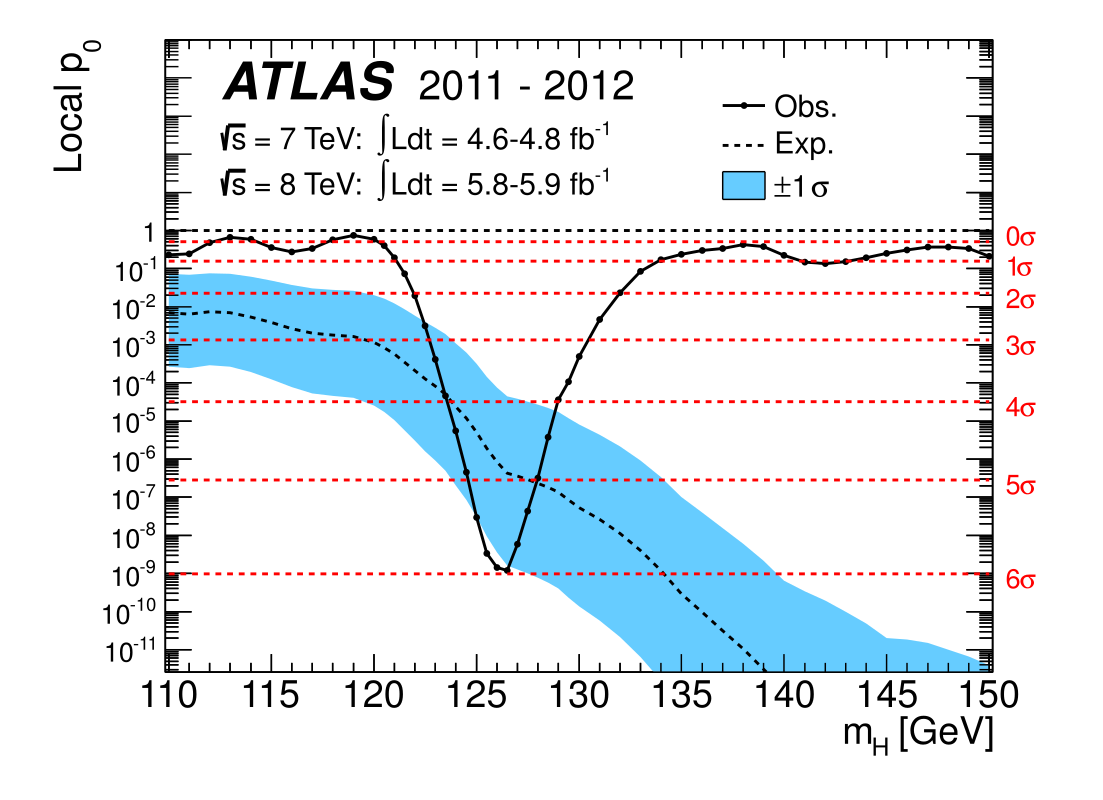

In [14]:
Image('higgs_discovery.png', width='80%')

## Basic concepts you should already have

### about probability

Given a (continuos) random variable $X$:
   * <strong>CDF</strong>: $F_X(x) = P(X\geq x)$
   * <strong>PDF</strong>: $f_X = \frac{dF_X}{dx}$
   * <strong>SF</strong>: $P(X<x) = 1 - F_X(x)$
   * <strong>Expected value</strong>
   $E[X] = \mu = \int x f_X(x) dx$
   * <strong>Variance</strong>: $V[X] = E[(X - \mu)^2]$
   * <strong>Covariance</strong>:   
   $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]} =  \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right]\operatorname{E}\left[Y\right]$


### Exercize
Explain the name "survival function"

### Exercize
   * Having a sample $\{x_i\}_i^n$, it is well know that $$s^2 = \frac{1}{n-1} \sum_{i=1}^n \left(x_i - \overline{x} \right)^2$$ is a unbiased estimator ($E[\text{bias}]=E[s^2 - V[X]] = 0$) for the variance
   * Show analytically that $\sqrt{s^2}$ is not an unbiased estimator for the standard deviation $\sigma_X=\sqrt{V[X]}$ (hint: $E$ is linear, $\sqrt{\,\,\,}$ is not)

#### Non-analytical solution

Let generate many pseudo-experiments (toys), to see the bias of $\sqrt{s^2}$. Every toy is made by a normal sample.

In [15]:
POPULATION_STD_DEV = 3  # standard deviation of the population
SIZE = 5                # size of the sample (for every toy)
NTOYS = 1000            # number of toys

# consider two versions of s^2 (with/without Bessel correction)
all_bias_std, all_bias_std_corr = [], []

for itoy in range(NTOYS):
    # generate a sample
    sample = np.random.normal(loc=0., scale=POPULATION_STD_DEV,
                              size=SIZE)
    
    # compute the bias for the two definitions
    all_bias_std.append(np.std(sample) - POPULATION_STD_DEV)
    all_bias_std_corr.append(np.std(sample, ddof=1) - POPULATION_STD_DEV)

Much faster code with vectorization

In [16]:
NTOYS = 1000000
samples = np.random.normal(loc=0., scale=POPULATION_STD_DEV,
                           size=(NTOYS, SIZE))
all_bias_std = np.std(samples, axis=1) - POPULATION_STD_DEV
all_bias_std_corr = np.std(samples, axis=1, ddof=1) - POPULATION_STD_DEV

In [17]:
# plot it
mean_bias_non_corr, err_bias_non_corr = [f(all_bias_std) for f in (np.mean, stats.sem)]
mean_bias_corr, err_bias_corr = [f(all_bias_std_corr) for f in (np.mean, stats.sem)]

fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(-1.2 * POPULATION_STD_DEV, 2 * POPULATION_STD_DEV, 100)
ax.hist(all_bias_std, bins, histtype='step', normed=True, label='non-corr %.3f$\pm$%.3f' % (mean_bias_non_corr, err_bias_non_corr))
ax.hist(all_bias_std_corr, bins, histtype='step', normed=True, label='corr %.3f$\pm$%.3f' % (mean_bias_corr, err_bias_corr))
bias_pdf = stats.chi(df=SIZE-1, loc=-POPULATION_STD_DEV, scale = POPULATION_STD_DEV / (np.sqrt(SIZE - 1) ))
bias_pdf_integral_window = bias_pdf.cdf(bins.max()) - bias_pdf.cdf(bins.min())
ax.plot(bins, bias_pdf.pdf(bins) / bias_pdf_integral_window, label='$\chi_{n-1}((\mathrm{bias} + \sigma) \sqrt{n - 1} / \sigma)$')
ax.set_xlabel('bias')
ax.legend()
plt.close()

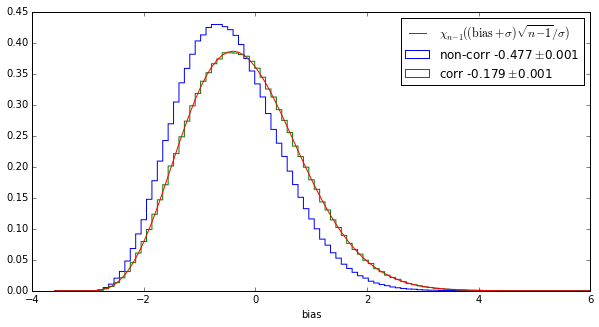

In [18]:
fig

<small>For a normal distribution $y^2\sim\chi^2_{n-1}$ with $y=\sqrt{n-1}s/\sigma$ by [Cochran's theorem](https://en.wikipedia.org/wiki/Cochran%27s_theorem), so in principle it is possibile to have an analytical expression for an unbiased estimator</small>

Can we draw a conclusions from these numbers? (answer=yes, detail in the rest of the lecture)

   * <strong>Statistic</strong>: a function of the data (the mean, the number of observed events, ...)
   * <strong>p-value</strong>: the probability to obtaining a result equal to or "more extreme" than what was actually observed
      * What "more extreme" means? It depends on question we want to answer
   
   
   * <strong>Conditional probability</strong> $P(A|B) = P(A\cap B) / P(B)$
      - 2% $\stackrel{?}{=}$ P(to be pregnant|to be woman) $\neq$ P(to be woman|to be pregnant) = 1
      - P(data|theory) $\neq$ P(theory|data)
   * <strong>Bayes theorem</strong> $P(A|B)P(B) = P(B|A)P(A)$
      * $P(\text{theory|data}) = P(\text{data|theory}) P(\text{theory})$
   * <strong>Likelihood</strong>: $\mathcal{L}(\theta|\text{data}) = P(\text{data}|\theta)$

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


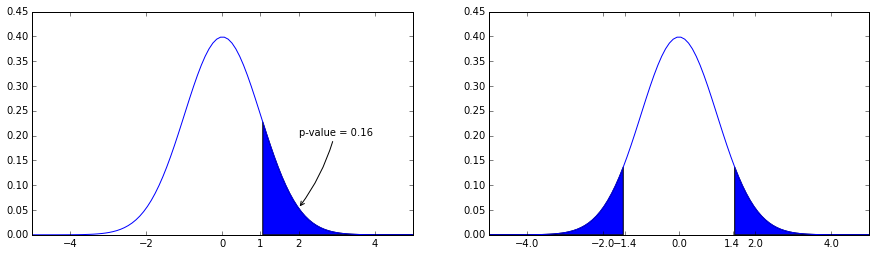

In [19]:
fig_gaussian, axs = plt.subplots(1, 2, figsize=(15, 4))
x = np.linspace(-5, 5, 100)
norm = stats.norm
y = norm.pdf(x)
z = 1.
mask = x > z
for ax in axs.flat:
    ax.plot(x, y)
axs[0].fill_between(x[mask], y[mask])
pvalue = norm.sf(z)
axs[0].annotate("p-value = %.2f" % pvalue, xy=(2, norm.pdf(2)), xytext=(z*2, 0.2), ha='left', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1", facecolor='black'))
axs[0].set_xticks(list(axs[0].get_xticks()) + [z])

z = norm.isf(pvalue / 2.)
axs[1].fill_between(x[x>z], y[x>z])
axs[1].fill_between(x[x<-z], y[x<-z])
axs[1].set_xticks(list(axs[1].get_xticks()) + [z, -z])

for ax in axs.flat:
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 0.45)

plt.show()


## Hypothesis testing

A statistical hypothesis is a hypothesis that is testable on the basis of observing a process that is modeled via a set of random variables

A statistical hypothesis test is a method of statistical inference

The goal of the hypothesis testing is to determine if the null ($H_0$) hypothesis can be
rejected. A statistical test can either reject (prove false) or fail to reject (fail to
prove false) a null hypothesis, but never prove it true (i.e., failing to reject a null
hypothesis does not prove it true).


### Example (binomial test one / two tail)

Are the students of this lecture equally distributed between male and female? Let's define the null hypothesis: "The students are equally distributed" and try to exclude it computing the p-value. The model is a binomial model, if we define $m = $ number of male student, $N$ the total number of student, $p$ the probability to have a male student, the null hypothesis is $p=1/2$.

$$ H_0: K\sim B(m| N, 1/2)$$

compute the p-value of the data, assuming $H_0$ to be true. What "more extreme" means in this case? Since usually there are more male students, "more extreme" means "more male student then the observed".

$$\text{p-value} = \sum P(m\geq m_{obs}) = \sum_{m\geq m_{obs}} B(m|N, 1/2)$$

pvalue =  0.0546875


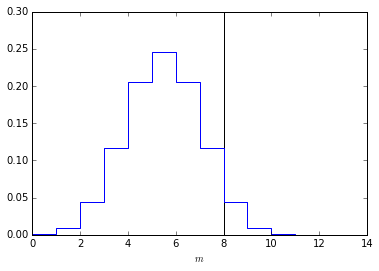

In [122]:
N = 10
nmale_obs = 8
print "pvalue = ", stats.binom(N, 0.5).sf(nmale_obs) + stats.binom(N, 0.5).pmf(nmale_obs)
x = np.arange(0, 15)
plt.plot(x, stats.binom(N, 0.5).pmf(x), drawstyle='steps-post')
plt.vlines(nmale_obs, 0., 0.3); plt.xlabel('$m$');

What if we all the students are female? Using the previous test we will find a very high p-value, and so we were not able to reject the null hypothesis. The problem is that we are looking to the right tail (more males). In that case we should change our definition of "more extreme".

Another solution is to perform a two-tailed test. In that case "more extreme" simply means less probable. What is the proobability to observe a number of male, less probable than the one observed? Note that in this case we are counting as "more extreme" cases where there are two many males (as before) or too few males.

$$\text{p-value} = \sum_{m: P(m) \leq P_{(m_{obs})}} P(m)$$

In [117]:
stats.binom_test(nmale_obs, N, 0.5)

0.10937500000000003

### Exercize:
Show that the two-tail p-value for a binomial with $p=1/2$ is two times the one-tail p-value (this is true only for $p=1/2$).

## Normal significance

Usually p-values are translated in a more-friendly normal-significance (number of sigmas) $z$. With the one-tail definition this is the value (quantile) corresponding to a certain p-value for a standard gaussian:

$$ \int_z^\infty N[x| 0, 1] dx = \text{p-value}$$

or $ \int_z^\infty + \int_{-\infty}^{-z} N[x|0,1] dx = \text{p-value}$ for the two-tail definition.

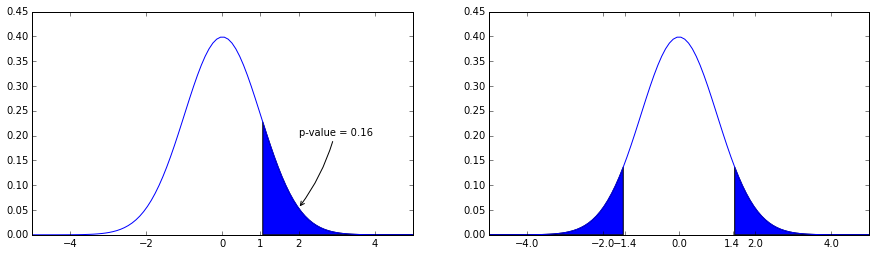

In [20]:
fig_gaussian

$$ \int_z^\infty N[x| 0, 1] dx = \text{p-value}$$

Taking into account the definition of the cumulative density function of a normal distribution, $\Phi(z) = \int_{-\infty}^{z} N[x| 0, 1] dx$, this can be written as:

$$ z = \Phi^{-1}(1 - \text{p-value})$$

or taking into account the definition of the survival function $SF(z) = 1 - CDF(z)$:

$$ z = \text{SF}^{-1}(\text{p-value})$$

### Question
What is the significance if p-value $\geq 0.5$? Note that in this case it means you are looking to the wrong tail.

In [21]:
def p2z(p_value, onetail=True):
    """ pvalue to significance """
    if not onetail:
        p_value /= 2
    return stats.norm.isf(p_value)  # inverse of the survival function

def z2p(z, onetail=True):
    """ significance to pvalue """
    if onetail:
        return stats.norm.sf(z)
    else:
        return stats.norm.sf(z) * 2

In [22]:
table = '<table float="left"><tr><td>p-value</td><td>z (one tail)</td><td>z (two tails)</td></tr>'
for p_value in np.logspace(-1, -8, 8):
    table += "<tr><td>%.5g</td><td>%.3f</td><td>%.3f</td></tr>" % (p_value, p2z(p_value), p2z(p_value, False))
table += "</table>"

table += '<table float="left"><tr><td>z (one tail)</td><td>p-value</td></tr>'
for z in np.arange(1, 7):
    pvalue = z2p(z)
    table += "<tr><td>%.2f</td><td>%.2g</td></tr>" % (z, pvalue)
table += "</table>"    

In [23]:
HTML(table)

In HEP usually we call "evidence" deviation at $3\sigma$ ($z=3$) and "discovery" at $5\sigma$. In other field much bigger p-values (smaller significance) are used.

<strong>Counting model</strong>: observed events $N_{obs}$ distributed as Poisson distribution. Observed events can be signal or background. We know the prediction (expected) for the background: $N_{bkg}^{exp}$. 

Question: is there a signal? Compute the p-value.
   * null hypothesis = background-only (expected signal = 0)
   * Observable: $N_{obs}$
   * Test-Statistic: $N_{obs}$

$P(N_{obs} | \text{no signal}) = \text{Poisson}[N_{obs}|N_{bkg}^{exp}]$. 

$$p_0 = \text{p-value for no signal} = \sum_{n\geq N_{obs}} P(n|\text{no signal}) =\sum_{n\geq N_{obs}} \text{Poisson}[n|N_{bkg}^{exp}]$$

#### Exercize
What "more extreme" means in this case? Why?
If we observe $n\ll N_{bkg}^{exp}$ will we observe a small p-value?

In [24]:
def simple_example_poisson(NBKG_EXP=50, NOBS=60, NSIG_EXP=10):
    pdf_b = stats.poisson(NBKG_EXP)
    p_value = pdf_b.sf(NOBS)
    print "p-value: {:f}  z: {:.2f}  s/sqrt(b): {:.2f}".format(p_value, p2z(p_value), (NOBS - NBKG_EXP) / np.sqrt(NBKG_EXP))
    
    #plot
    x = np.arange(0, NBKG_EXP * 2)
    y = pdf_b.pmf(x)
    plt.plot(x, y, linestyle='steps', label='$P(N_{obs}|s=0)$')
    plt.plot(x, stats.poisson(NBKG_EXP + NSIG_EXP).pmf(x), linestyle='steps', alpha=0.3, label='$P(N_{obs}|s=%d)$' % NSIG_EXP)
    #plt.step(x, y, fillcolor='red')
    #plt.fill_between(x, y, steps='pre')
    plt.vlines(NOBS, 0, pdf_b.pmf(NOBS))
    plt.legend(loc=0)
    plt.xlim(0, 300)
    plt.draw()

p-value: 0.000053  z: 3.88  s/sqrt(b): 4.13


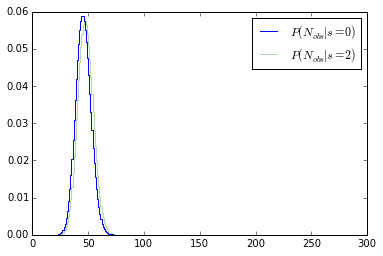

In [25]:
interact(simple_example_poisson, NBKG_EXP=50, NOBS=60, NSIG_EXP=10)


   * Note that exclusing the null-hypothesis doesn't mean that we consider the alternative hypothesis true.   
   * Note that what we have computed is $P(N_\text{obs} | \text{no signal})$, which can be written more generally as $P(\text{data}|\text{theory})$, so we are computing a probability about data.
   * We are not computing a probability about the model ($P(\text{theory})$, which is what we want to know!)
   * Remember the definition of probability in the frequenstis approach $P(E) = \lim_{N\to\infty}\frac{n}{N}$, where $n$ is the number of occurrences of an event $E$ in $N$ trials. This can only be applied to repeatable events
   * Only in a Bayesian framework you can aswer (or compute the relative probability) questions like "Is there the Higgs boson?", "Will it rain tomorrow?", "Was Napoleon murdered?"
   
> "Bayesians address the question everyone is interested in, by using
> assumptions no-one believes"

> "Frequentists use impeccable logic to deal with an issue of no interest to
>anyone"
L. Lyons
  

   

## Expected significance

Let evaluate the significance as a function of the luminosity $L$. $b = L\sigma_{bkg}\varepsilon_{bkg}$, $s = L\sigma_{sig}\varepsilon_{sig}$. Compute the expected significance from the p-value from the Poisson model, $s/\sqrt{b}$ and $\sqrt{2  ((s + b)  \log(1 + s / b) - s}$ assuming that there is signal.

$$\text{p-value} = \sum_{n\geq n_\text{obs}} \text{Pois}(n|n_b)$$

$$\text{p-value expected} = \sum_{n\geq {s + b}} \text{Pois}(n|n_b)$$

In [26]:
def eval_sensitivity(bkg_xsec=1000, signal_xsec_exp=10., signal_efficiency=0.8, bkg_rejection=100, max_lumi=8.):
    luminosities = np.linspace(1E-9, max_lumi, 200)

    pvalues, zs = [], []
    for lumi in luminosities:
        nsignal_exp = lumi * signal_xsec_exp * signal_efficiency
        nbkg_exp = lumi * bkg_xsec / bkg_rejection
        p_value = stats.poisson(nbkg_exp).sf(nsignal_exp + nbkg_exp) + stats.poisson(nbkg_exp).pmf(nsignal_exp + nbkg_exp)
        pvalues.append(p_value)
        zs.append(p2z(p_value))

    s = luminosities * signal_xsec_exp * signal_efficiency  
    b = luminosities * bkg_xsec / bkg_rejection
    
    approximation_z = s / np.sqrt(b)
    formula_z = np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))
        
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(luminosities, zs, label='$z$')
    axs[0].plot(luminosities, approximation_z, '--', label='$s/\sqrt{b}$')
    axs[0].plot(luminosities, formula_z, '--', label='$\sqrt{2 ((s + b)  \log(1 + s / b) - s)}$')
    axs[0].set_ylim(0, 7); axs[1].set_ylim(1E-8, 0.5)
    axs[0].set_ylabel('significance')
    axs[0].legend(loc=0)
    axs[0].text(0.05, 0.8, '$s=L\sigma_S\epsilon_S = %.2f L$' % (signal_xsec_exp * signal_efficiency), transform=axs[0].transAxes)
    axs[0].text(0.05, 0.9, '$b=L\sigma_b\epsilon_b = %.2f L$' % (bkg_xsec / bkg_rejection), transform=axs[0].transAxes)
    axs[1].semilogy(luminosities, pvalues)
    axs[1].set_ylabel('$p_0$')
    
    axs[1].hlines([z2p(z) for z in range(7)], 1E-9, max_lumi, linestyles='--', alpha=0.3)
    
    for ax in axs.flat:
        ax.set_xlabel('luminosity')

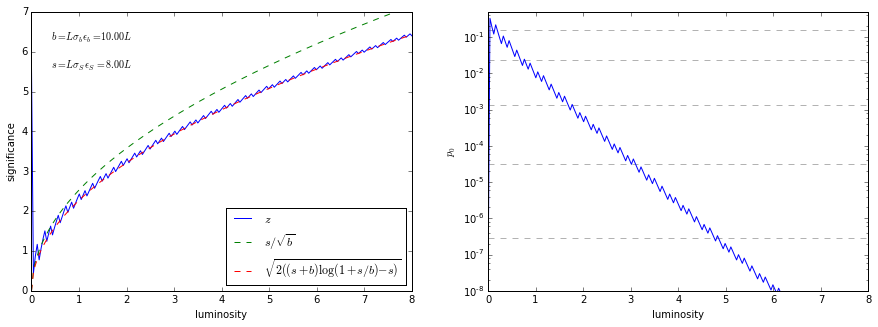

In [123]:
eval_sensitivity = interact(eval_sensitivity, bkg_xsec=(10, 10000),
                            signal_xsec_exp=(0.1, 20),
                            signal_efficiency=(0.7, 1, 0.01),
                            bkg_rejection=(3, 500, 10),
                            max_lumi=(1, 100))

### Exercize
Explain the discontinuities in the previous plots.
### Exercize
Derive the approximation for the median expected significance $z\simeq s/\sqrt{b}$ when $s\ll b$. Hint: use gaussian approximation of the Poisson distribution.

### RooFit 1.0.1

In [28]:
ws_example = ROOT.RooWorkspace('ws_example')
ws_example.factory("RooGaussian:signal(x[-5, 5], mean[0, -1, 1], sigma[1, 0.1, 2])")
x = ws_example.var('x')
data = ws_example.pdf('signal').generate(ROOT.RooArgSet(x), 1000)
ws_example.pdf('signal').fitTo(data);

[#1] INFO:Minization -- RooMinuit::optimizeConst: activating const optimization
 **********
 **   13 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=1457.87 FROM MIGRAD    STATUS=INITIATE        8 CALLS           9 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  mean         0.00000e+00   2.00000e-01   2.01358e-01  -2.68014e+01
   2  sigma        1.00000e+00   1.90000e-01   2.01653e-01  -7.38752e+01
                               ERR DEF= 0.5
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 COVARIANCE MATRIX CALCULATED SUCCESSFULLY
 FCN=1456.09 FROM MIGRAD    STATUS=CONVERGED      29 CALLS          30 TOTAL
                 

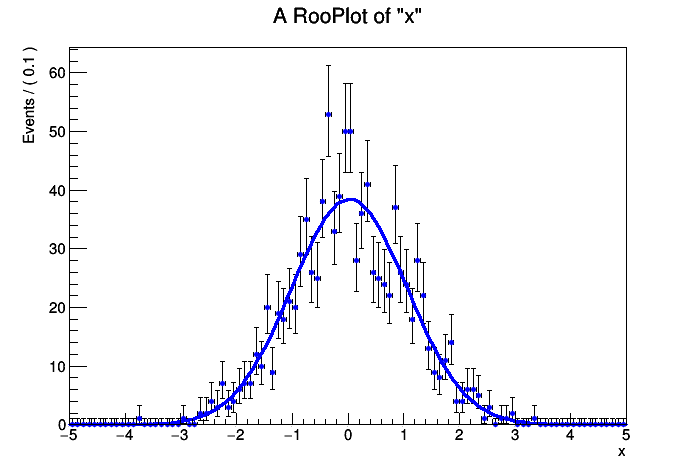

In [29]:
frame = x.frame()
data.plotOn(frame)
ws_example.pdf('signal').plotOn(frame)
canvas = ROOT.TCanvas()
frame.Draw()
canvas.Draw()

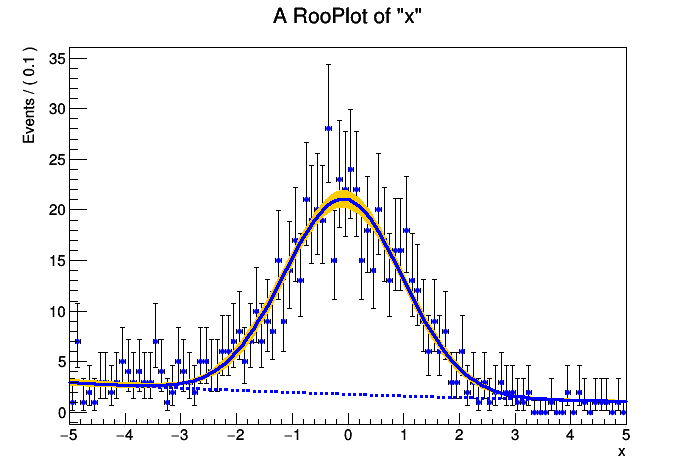

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinuit::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (background)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (signal)
 **********
 **   13 **MIGRAD        2000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-2563.07 FROM MIGRAD    STATUS=INITIATE       14 CALLS          15 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  b            2.00000e+02   1.00000e+02   1.05570e-01   1.08441

In [30]:
ws_example.factory("RooExponential:background(x, tau[-0.1])")
model = ws_example.factory("SUM:model(s[500, 0, 2000] * signal, b[200, 0, 5000] * background)")
frame = x.frame()
data = ws_example.pdf("model").generate(ROOT.RooArgSet(x))
data.plotOn(frame)
result = model.fitTo(data, RooFit.Save())
model.plotOn(frame, RooFit.VisualizeError(result, 1), RooFit.FillColor(ROOT.kOrange), RooFit.DrawOption("F"))
model.plotOn(frame)
model.plotOn(frame, RooFit.Components('background'), RooFit.LineStyle(ROOT.kDashed))
frame.Draw(); ROOT.c1.Draw()

## Counting models with RooFit / RooStats

In [128]:
S, B = 10, 20  # expected values

ws_poisson = ROOT.RooWorkspace('ws_poisson')  # create the workspace
b = ws_poisson.factory("b[%f]" % B)  # create constant variable
n_exp = ws_poisson.factory("sum::n_exp(s[%f], b)" % S)  # S + B
# create a Poisson pdf, with n_exp expected events
pdf = ws_poisson.factory("Poisson::pdf(n_obs[0, 100], n_exp)")
# generate a random experiment with S + B
aset = ROOT.RooArgSet(ws_poisson.var('n_obs'))
data = pdf.generate(aset, 1)  # generate with 1 entry
n_obs_val = data.get(0).first().getVal()

### Exercize
Explain why for a counting experiment we generate a dataset with 1 entry

We expect to observe $s+b =$ {{S}} + {{B}} = {{n_exp.getVal()}} events if there is a signal and {{B}} if there is only background. We observe {{n_obs_val}}. Is there a signal?

We have just defined the pdf(s) and the variables of the model, but the meaning of the various items is not defined (what is our observables?). `ModelConfig`: it bind the RooFit world (just define the model) to RooStats world (do inference with the model).

Create two `ModelConfig`s for null (bkg-only) and alternate hypothesis (s+b)

In [129]:
# create a MC linked to the ws
sbModel = RooStats.ModelConfig("sbmodel", ws_poisson)   
sbModel.SetPdf(pdf)
sbModel.SetObservables('n_obs')  # it understands variable-names
sbModel.SetParametersOfInterest('s')
# save the value of s for (s+b)-hypothesis
sbModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(sbModel)  # import is a keyword in python

bModel = sbModel.Clone("bmodel")  # create a bkg-only model
ws_poisson.var('s').setVal(0)             # with no signal
bModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(bModel);

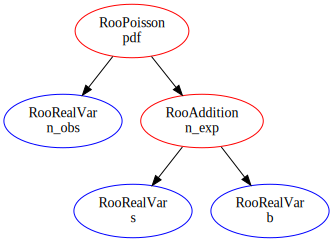

In [130]:
pdf.graphVizTree("pdf_graph.dot")
!dot -Tsvg pdf_graph.dot > pdf_graph.svg; rm pdf_graph.dot
SVG("pdf_graph.svg")

In [131]:
ws_poisson.Print()


RooWorkspace(ws_poisson) ws_poisson contents

variables
---------
(b,n_obs,s)

p.d.f.s
-------
RooPoisson::pdf[ x=n_obs mean=n_exp ] = 7.63019e-09

functions
--------
RooAddition::n_exp[ s + b ] = 20

parameter snapshots
-------------------
sbmodel__snapshot = (s=10[C])
bmodel__snapshot = (s=0[C])

named sets
----------
bmodel__snapshot:(s)
sbmodel_Observables:(n_obs)
sbmodel_POI:(s)
sbmodel__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::sbmodel
RooStats::ModelConfig::bmodel



As we have done before, for the simple counting experiment, we have used as statistic the observables directly: `n_obs`. 

In [132]:
test = RooStats.NumEventsTestStat(pdf)
test.Evaluate(data, ROOT.RooArgSet(ws_poisson.var('s')))

32.0

The only missing ingredient is the distribution of the statistics, but in this trivial example we have defied it to be the number of observed events, so it is Poissonian by definition. What to do in more complicated case (many entries for 1 events, or just in case I want to use the squared number of events)?
   * rely on asymtotic formulas (if any)
   * general and expensive method: run pseudo-experiments (toys), see next slide

## Usage of `ToyMCSampler`

In [133]:
toy_sampler = RooStats.ToyMCSampler(test, 100000)  # configure the number of toys
toy_sampler.SetNEventsPerToy(1)                    # it is a counting experiment
toy_sampler.SetObservables(bModel.GetObservables())
toy_sampler.SetParametersForTestStat(bModel.GetParametersOfInterest())
toy_sampler.SetPdf(pdf)

test_distribution_b = toy_sampler.GetSamplingDistribution(
    bModel.GetParametersOfInterest())

plot_test_distribution = RooStats.SamplingDistPlot(60, 0, 60)
cuts = [test_distribution_b.InverseCDF(1 - z2p(z)) for z in range(1, 4)]
for cut in cuts:
    plot_test_distribution.AddSamplingDistributionShaded(test_distribution_b, -1000, cut)
plot_test_distribution.AddSamplingDistribution(test_distribution_b)

canvas = ROOT.TCanvas()
plot_test_distribution.Draw()

[#0] PROGRESS:Generation -- generated toys: 500 / 100000
[#0] PROGRESS:Generation -- generated toys: 1000 / 100000
[#0] PROGRESS:Generation -- generated toys: 1500 / 100000
[#0] PROGRESS:Generation -- generated toys: 2000 / 100000
[#0] PROGRESS:Generation -- generated toys: 2500 / 100000
[#0] PROGRESS:Generation -- generated toys: 3000 / 100000
[#0] PROGRESS:Generation -- generated toys: 3500 / 100000
[#0] PROGRESS:Generation -- generated toys: 4000 / 100000
[#0] PROGRESS:Generation -- generated toys: 4500 / 100000
[#0] PROGRESS:Generation -- generated toys: 5000 / 100000
[#0] PROGRESS:Generation -- generated toys: 5500 / 100000
[#0] PROGRESS:Generation -- generated toys: 6000 / 100000
[#0] PROGRESS:Generation -- generated toys: 6500 / 100000
[#0] PROGRESS:Generation -- generated toys: 7000 / 100000
[#0] PROGRESS:Generation -- generated toys: 7500 / 100000
[#0] PROGRESS:Generation -- generated toys: 8000 / 100000
[#0] PROGRESS:Generation -- generated toys: 8500 / 100000
[#0] PROGRESS:G

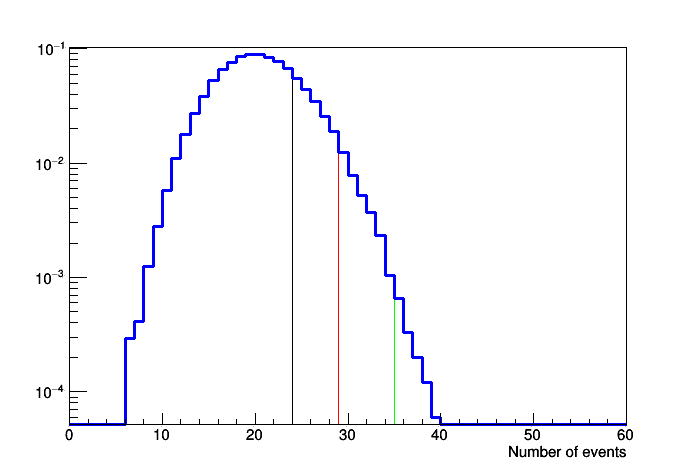

In [135]:
canvas.SetLogy()
canvas.Draw()

We observed {{n_obs_val}}. The values corresponding to significance of 1,2,3,4 are shown. Too many toys are needed for high-significance, since we have to probe the tail of the distribution. Frequentist approach very expensive.

Let use the `FrequentistCalculator` to compute the $p_0$ which use the `ToyMCCalculator` for both the hypotheses to compute the p-values. `FrequentistCalculator` is a `HypoTestCalculator` and returns a `HypoTestResults` via `GetHypoTest`, which contain the test results (p-values, ...)

In [136]:
# the sb model is not really needed in this case
hypoCalc = RooStats.FrequentistCalculator(data, sbModel, bModel)
hypoCalc.SetToys(20000, 1000)  # generate much more toys for bkg-only

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(test)  # our test statistics
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)


=== Using the following for bmodel ===
Observables:             RooArgSet:: = (n_obs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::pdf[ x=n_obs mean=n_exp ] = 7.63019e-09
Snapshot:                
  1) 0x102b3930 RooRealVar:: s = 0 C  L(-INF - +INF)  "s"


=== Using the following for sbmodel ===
Observables:             RooArgSet:: = (n_obs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::pdf[ x=n_obs mean=n_exp ] = 7.63019e-09
Snapshot:                
  1) 0x102b3930 RooRealVar:: s = 10 C  L(-INF - +INF)  "s"

[#0] PROGRESS:Generation -- Test Statistic on data: 32
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0] PROGRESS:Generation -- generated toys: 500 / 20000
[#0] PROGRESS:Generation -- generated toys: 1000 / 20000
[#0] PROGRESS:Generation -- generated toys: 1500 / 20000
[#0] PROGRESS:Generation -- generated toys: 2000 / 20000
[#0] PROGRESS:Generation -- generated toys: 2500 / 20000

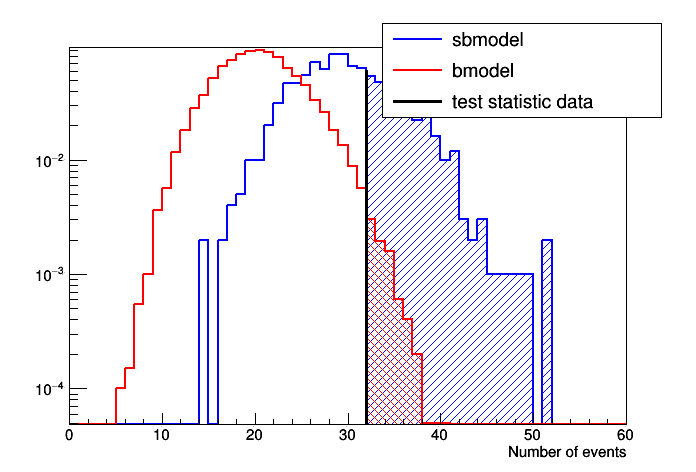

(frequentist)        p0 = 0.008 ± 0.0006  z = 2.41 ± 0.03
(from Poisson distr) p0 = 0.0081  z = 2.40


<IPython.core.display.Latex object>

In [139]:
plot = RooStats.HypoTestPlot(htr, 60, 0, 60)  # 60 bins
canvas = ROOT.TCanvas(); plot.Draw(); canvas.SetLogy(); canvas.Draw()
print u"(frequentist)        p0 = %.2g ± %.1g  z = %.2f ± %.1g" % (htr.NullPValue(), htr.NullPValueError(), htr.Significance(), htr.SignificanceError())
p0_poisson = stats.poisson(B).sf(n_obs_val) + stats.poisson(B).pmf(n_obs_val)
print "(from Poisson distr) p0 = %.2g  z = %.2f" % (p0_poisson, p2z(p0_poisson))
Latex("$\sqrt{2(n \log(n/b) + b - n)} = %.2f$" % np.sqrt(2 * (n_obs_val * np.log(n_obs_val / B) + B - n_obs_val)))

## Example of test-statistics

A famous journalist makes a regular survey every day, using a sample of 1000 random people. One day the fraction of citizen who trust the government is 55%, while the day after is 51%. Can we say there is a change in opinions (using $\alpha=5\%$)?

Let's write the contingency table

|      | day1    | day2  |       |
|------|---------|-------|-------|
| yes  |   550   |  510  |  1060 |
| no   |   450   |  490  |   940 |
|      |  1000   | 1000  |  2000 |

Null hypothesis: day1 and day2 are from the same population. What will be the expected contingency table in that case?

In [40]:
table = pd.DataFrame([[550, 510], [450, 490]], columns=['day1', 'day2'], index=['yes', 'no'])
pd.DataFrame(stats.contingency.expected_freq(table), columns=['day1', 'day2'], index=['yes', 'no'])

,day1,day2
yes,530,530
no,470,470


Define the test statistics: $\chi^2 = \sum_{i,j}\frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}$ where $O$ and $E$ are the observed and expected values, while the index $i,j$ identify a cell of the table. The test statistics $\chi^2$ is approximatively distributed as a $\chi^2$-distribution with $(\text{nrows} - 1)(\text{ncolumns} - 1)=1$ degree of freedom.

In [41]:
chi2, p, dof, _ = stats.contingency.chi2_contingency(table)
print "chi2 = %.2f ndof = %d p-value = %.3e" % (chi2, dof, p)

chi2 = 3.05 ndof = 1 p-value = 8.059e-02


We can't reject the null hypothesis. The exact solution is made with the [Fisher exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test), which used the hypergeometric distribution

In [42]:
print "p-value = %.3e" % stats.fisher_exact(table)[1]

p-value = 8.056e-02


# Lecture 2

<p style="text-align: center;"><i class="icon-user icon-2x"> [ruggero.turra@mi.infn.it](mailto:ruggero.turra@mi.infn.it)</i></p>
<br/>

## Content of the lecture

   * Hypothesis testing
   * Type or errors
   * Likelihood ratio
   * Neyman–Pearson lemma
   * Exclusions
   * Profiled likelihood ratio

## Simple and composite hypothesis

* A simple hypothesis is one in which all parameters of the distribution are specified

## Error type

   * Type I error: false positive (excessive credulity). Rate = $\alpha = P(\text{reject } H_0|H_0 \text{ is true})$
   * Type II error: false negative (excessive skepticism). Rate = $\beta = P(\text{don't reject } H_0|H_0 \text{ is false})$
   
   * Power of the test: $1-\beta$
   * Remember that "true"/"false" refers to $H_1$, the alternative hypothesis

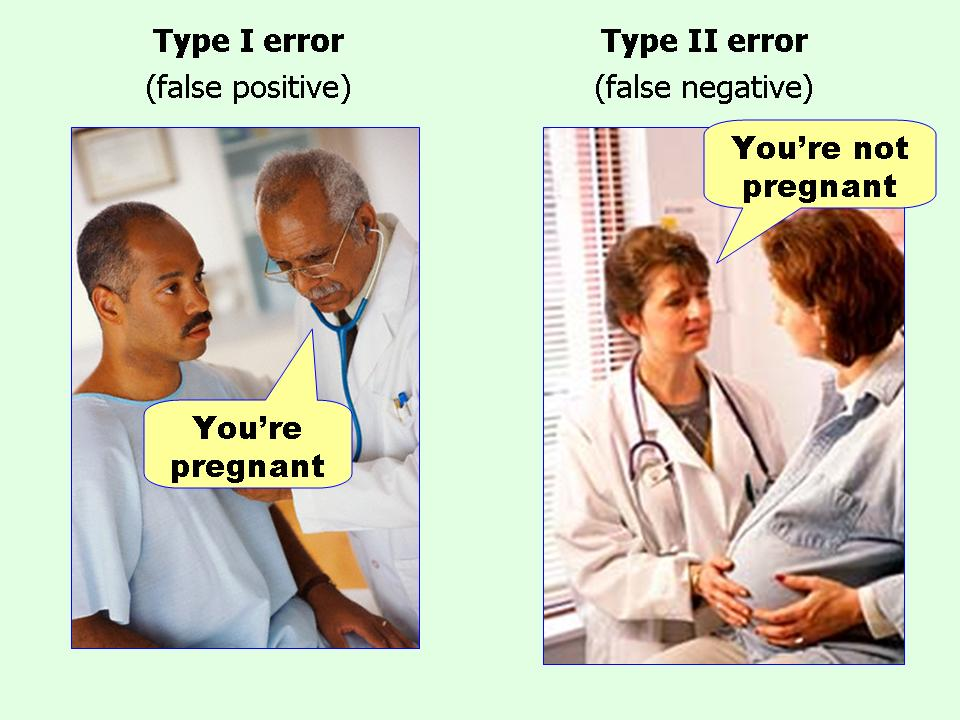

In [43]:
Image("img/type-i-and-type-ii-errors.jpg", width="70%")  # from https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg

### Exercize:
what is $H_0$ and $H_1$ in this sketch?

In [44]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(10, 7))
    x = np.linspace(-5, 5, 200)
    y0 = stats.norm.pdf(x, 0, 1)
    y1 = stats.norm.pdf(x, 1, 1)
    mask = x >= 2
    ax.plot(x, y0, x, y1, '-')
    ax.fill_between(x[mask], y0[mask], alpha=0.5)
    ax.fill_between(x[~mask], y1[~mask], alpha=0.5, color='green')
    ax.vlines(2, 0, 0.5, lw=2)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.set_xlabel("$q$")
    ax.annotate("$f(q|H_1)$", xy=(x[100], y1[100]), xytext=(0.2, 0.7), textcoords="figure fraction", size=20,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='green')
    ax.annotate("$f(q|H_0)$", xy=(x[90], y0[90]), xytext=(-0.75, 0.8), textcoords="figure fraction", size=20,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='blue')
    ax.annotate(r"$\beta$", xy=(x[100], 0.1), xytext=(0.1, 0.5), textcoords="figure fraction", size=20,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='green')
    ax.annotate(r"$\alpha$", xy=(x[142], 0.01), xytext=(0.8, 0.25), textcoords="figure fraction", size=20,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), color='blue')
    ax.text(2, 0.4, r'$q_\alpha$', rotation='vertical', ha='right', size=20)
plt.close()

/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Humor Sans', u'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


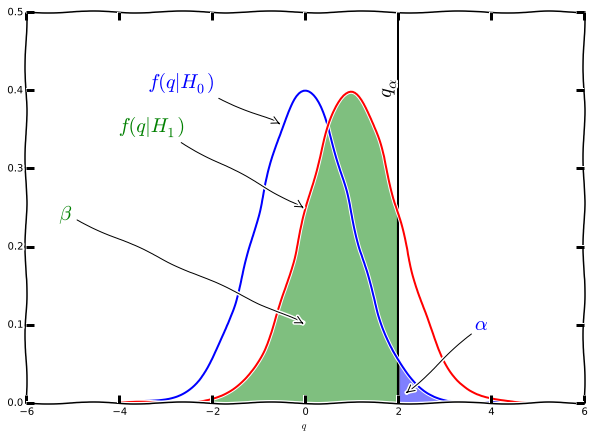

In [45]:
fig

Note that to evaluate $\beta = P(\text{don't reject } H_0|H_0 \text{ is false})$ we have used an altenative hypothesis $H_1$, but remember that if $H_0$ is false doesn't mean that $H_1$ is true.

The region $q > q_\alpha$ is the acceptance region. The complementary is the rejection region.

## Hypothesis testing in practice

   * Define the null hypothesis you want to try to reject
   * Define the observables (number of events in the signal region, ...)
   * Fix the rate of type I error $\alpha$ of the test statistics (5%, $5\sigma$, ...)
   * Define the test statistic (trying to maximize the power $1-\beta$)
   * Find the acceptance region in the observable space, which is the region where $H_0$ is accepted (p-value $<\alpha$)
   * Do the experiment
   * If the outcome is outside the acceptance region reject the null-hypothesis
   
In complex example one don't compute the acceptance region, but just compute the observed p-value

### Exercize (big): Lady tasting tea (Fisher "The Design of Experiments" - 1935)

A lady claimed to be able to tell whether the tea or the milk was added first to a cup. Fisher proposed to give her eight cups, four of each variety, in random order. What is the critical region at 5%? If we ask for a $5\sigma$ evidence, what's the minimum amount of cups we have to prepare? (Hint: look at the [Hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution), answer should be 26)

Suppose the lady claimed that she can guess at least 90% of the time the right answer. What is the power of the test in the two cases?

Are we interested in the rare case when the lady never guess? What is "more extreme" in this case?

## Neyman–Pearson lemma
Having two simple hypotheses (no additional parameters) $H_0: \theta = \theta_0$ and $H_1: \theta = \theta_1$, the likelihood-ratio test:
$$
\Lambda(x) = \frac{L(\theta_0|x)}{L(\theta_1|x)}
$$

which rejects $H_0$ in favour of $H_1$ when $\Lambda \leq k_\alpha$ (rejection region) with $\alpha=P(\Lambda(X)\leq k_\alpha|H_0)$ is the most powerful test with size $\alpha$.

### Example
Suppose you have a rock that seems to be opal (density 2.2 g/cm<sup>3</sup>), but may be also quarz (2.6 g/cm<sup>3</sup>). You have two instruments to measure the density, the first with resolution 0.2, the second with resolution 0.5. What is the rejection region at 5%? Assume gaussian errors.

In [46]:
ws = ROOT.RooWorkspace()
true_density = ws.factory("true_density[2, 3]")
ws.factory("Gaussian::pdf1(density1[0,50], true_density, resolution1[0.5])")
ws.factory("Gaussian::pdf2(density2[0,50], true_density, resolution2[0.2])")
pdf = ws.factory("PROD::pdf(pdf1, pdf2)")

pdf_opal = ws.factory("EDIT:pdf_opal(pdf, true_density=density_opal[2.2])")
pdf_quarz = ws.factory("EDIT:pdf_quarz(pdf, true_density=density_quarz[2.6])")

In [47]:
# do the experiment
data = pdf_quarz.generate(ROOT.RooArgSet(ws.var('density1'),
                                         ws.var('density2')), 1)  # generate with 1 entry
data.get(0).Print("V")

  1) RooRealVar:: density1 = 3.31624
  2) RooRealVar:: density2 = 2.38958


In [48]:
opal_model = RooStats.ModelConfig("opal", ws)   
opal_model.SetPdf(pdf_opal)
opal_model.SetParametersOfInterest('density_opal')  # not useful
opal_model.SetObservables('density1,density2')  # no space
opal_model.SetSnapshot(ROOT.RooArgSet(ws.var('density_opal')))

quarz_model = opal_model.Clone("quarz")
quarz_model.SetParametersOfInterest('density_quarz')  # not useful
quarz_model.SetPdf(pdf_quarz)

In [49]:
# define the test-statistic

test = RooStats.SimpleLikelihoodRatioTestStat(pdf_opal, pdf_quarz)  # null, alt
test.EnableDetailedOutput(True)

hypoCalc = RooStats.FrequentistCalculator(data, quarz_model, opal_model)  # alt, null
hypoCalc.SetToys(20000, 1000)  # generate much more toys for bkg-only

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(test)  # our test statistics
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)


=== Using the following for opal ===
Observables:             RooArgSet:: = (density1,density2)
Parameters of Interest:  RooArgSet:: = (density_opal)
PDF:                     RooProdPdf::pdf_opal[ pdf1_pdf_opal * pdf2_pdf_opal ] = 0
Snapshot:                
  1) 0xd6bd2d0 RooRealVar:: density_opal = 2.2 C  L(-INF - +INF)  "density_opal"


=== Using the following for quarz ===
Observables:             RooArgSet:: = (density1,density2)
Parameters of Interest:  RooArgSet:: = (density_quarz)
PDF:                     RooProdPdf::pdf_quarz[ pdf1_pdf_quarz * pdf2_pdf_quarz ] = 0
Snapshot:                
  1) 0xd3ea9d0 RooRealVar:: density_opal = 2.2 C  L(-INF - +INF)  "density_opal"

[#0] PROGRESS:Generation -- Test Statistic on data: 1.36175
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0] PROGRESS:Generation -- generated toys: 500 / 20000
[#0] PROGRESS:Generation -- generated toys: 1000 / 20000
[#0] PROGRESS:Generation -- generated toys: 1500 / 20000
[#0] 

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: quarz (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: opal (Potential memory leak).


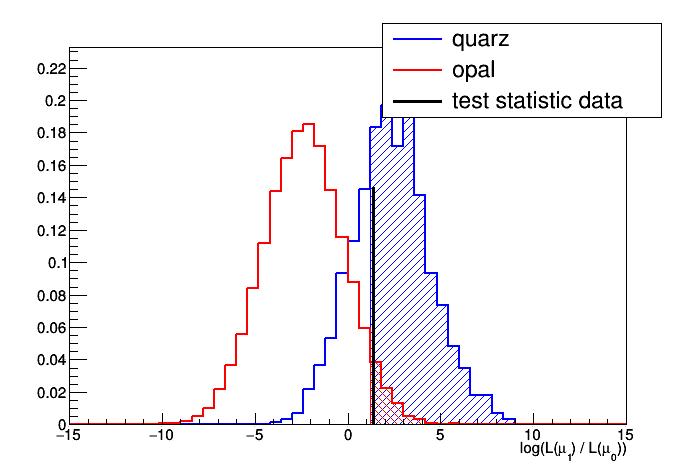

In [50]:
plot = RooStats.HypoTestPlot(htr, 50, -15, 15)
canvas = ROOT.TCanvas()
plot.Draw()
canvas.Draw()

In [51]:
print "observed p-value: ", htr.NullPValue()

alpha = 0.05
kalpha = htr.GetNullDistribution().InverseCDF(1 - alpha)
beta = htr.GetAltDistribution().CDF(kalpha)
print "k_alpha = ", kalpha
print "power = ", 1 - beta

observed p-value:  0.04305
k_alpha =  1.20919914471
power =  0.715


### Exercize
Show that the in this case the likelihood ratio is equivalent to the weighted mean of the two measurements

In [52]:
def eval_test_stat():
    d = ROOT.RooDataSet("d", "d", ROOT.RooArgSet(ws.var('density1'), ws.var('density2')))
    d.add(ROOT.RooArgSet(ws.var('density1'), ws.var('density2')))
    return test.Evaluate(d, ROOT.RooArgSet(ws.var('true_density')))

fig_opal, ax = plt.subplots(figsize=(12, 7))

x = np.linspace(1.3, 3.5, 100)
y = np.linspace(1.5, 3.5, 100)

qvalues = np.zeros((len(x), len(y)))
pdf_opal_values = np.zeros((len(x), len(y)))
pdf_quarz_values = np.zeros((len(x), len(y)))
for ix, xx in enumerate(x):
    for iy, yy in enumerate(y):        
        ws.var('density1').setVal(xx)
        ws.var('density2').setVal(yy)
        qvalues[iy, ix] = eval_test_stat()
        pdf_opal_values[iy, ix] = pdf_opal.getVal()
        pdf_quarz_values[iy, ix] = pdf_quarz.getVal()
        
c = plt.pcolormesh(x, y, qvalues, cmap=colormaps.viridis)
cs = ax.contour(x, y, qvalues, [kalpha], linestyles='dashed')
ax.clabel(cs, fontsize=14, fmt=r"$k_\alpha$ = %1.3f", inline_spacing=30, use_clabeltext=True)
ax.contour(x, y, pdf_opal_values, cmap='Blues', alpha=0.6)
ax.contour(x, y, pdf_quarz_values, cmap='Oranges', alpha=0.6)
ax.text(1.5, 1.6, "accept", size=20)
ax.text(1.8, 3.2, "reject", size=20)
datalist = [x.getVal() for x in iter_collection(data.get(0))]
ax.plot(datalist[0], datalist[1], 'v', label='observed')

ax.set_xlabel('density1')
ax.set_ylabel('density2')
ax.legend()
ax.set_aspect('equal')
plt.colorbar(c)
plt.close()

Since we have just two observables we can easily show the acceptance / rejection region in the space of the observables

/usr/lib64/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/lib64/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


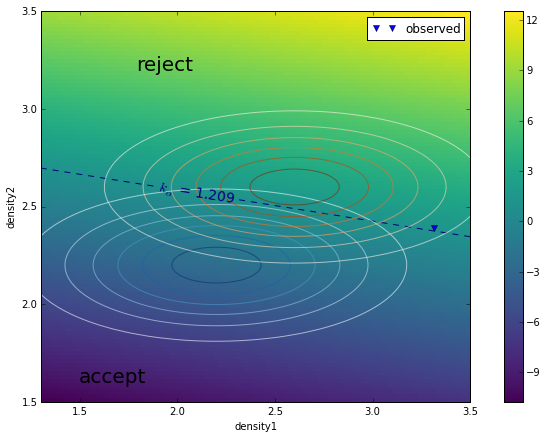

In [53]:
fig_opal

### Exercize
Compute the acceptance region using the simple mean as test-statistics: show that it is less powerful

### Plot the power as a function of the size of the test for the likelihood ratio

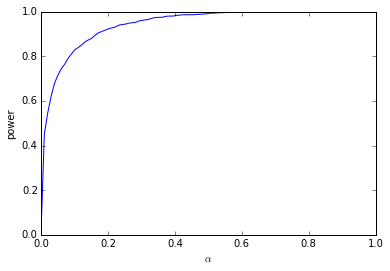

In [54]:
alphas = np.linspace(0, 1, 100)
powers = []

for alpha in alphas:
    kalpha = htr.GetNullDistribution().InverseCDF(1 - alpha)
    beta = htr.GetAltDistribution().CDF(kalpha)
    powers.append(1 - beta)
    
plt.plot(alphas, powers)   
plt.xlabel(r'$\alpha$')
plt.ylabel(r'power')
plt.show()

### Exercize
Compute $\text{power}(\alpha)$ for the simple mean
### Exercize
Explain why the previous plot remembers the ROC curve (bkg-rejection vs signal-efficiency).

## Exclusion and frequentist intervals

By now we have done statistical test to discover something (a signal), defining the null hypothesis to be the background only case. Suppose we have counted $n_{obs}$ events in a Poissonian process with mean $\lambda$. What are the values $[n_{up}, \infty]$ that we can exclude? This is something called hypothesis inversion. As usual we define the null hypothesis: $H_0: \lambda = N$ with $N > n_{obs}$. The likelihood:

$$L = \text{Pois}(n|N)$$

than the p-value of our observation $n_{obs}$:

$$\text{p-value} = \sum_{n\geq n_{obs}} \text{Pois}(n|N)$$

if p-value $<\alpha$ we consider $N$ to be inside the exluded region $[n_{up}, \infty]$. The general approach is to scan for many value of $N$ until we found the one with p-value $=\alpha$, which is $n_{up}$.

### Example: RooFit asymmetric error bars

Let's do a two-side test and compute the excluded intervals $[-\infty, n_{down}]$ and $[n_{up}, \infty]$ with $\alpha=1 - 0.6827$. This means that every single interval should be tested with $\alpha=(1-0.6827)/2.=0.15865$. We can solve it analytically or with a scan. Suppose $n_{obs} = 3$.

In [55]:
NOBS = 4
ALPHA = z2p(1)  # 0.158...

def compute_pvalue(nobs, ntrue, left):
    if left:
        return stats.poisson(ntrue).cdf(nobs)
    else:
        return stats.poisson(ntrue).sf(nobs) + stats.poisson(ntrue).pmf(nobs)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))
x = np.linspace(NOBS, NOBS + 3 * NOBS, 20)

axs[1].plot(x, compute_pvalue(NOBS, x, left=True), 'r')
axs[1].hlines(ALPHA, np.min(x), np.max(x), linestyles='--')

x = np.linspace(max(NOBS - NOBS * 3, 0), NOBS, 20)
axs[0].plot(x, compute_pvalue(NOBS, x, left=False), 'b')
axs[0].hlines(ALPHA, np.min(x), np.max(x), linestyles='--')

from scipy.optimize import brenth
nup = brenth(lambda x: compute_pvalue(NOBS, x, True) - ALPHA, NOBS, NOBS * 3)
ndown = brenth(lambda x: compute_pvalue(NOBS, x, False) - ALPHA, 1E-5, NOBS)

axs[1].plot(nup, compute_pvalue(NOBS, nup, True), 'ro')
axs[0].plot(ndown, compute_pvalue(NOBS, ndown, False), 'bo')
axs[1].set_xlabel('N'); axs[0].set_xlabel('N')
axs[1].set_ylabel('$P(n\leq n_{obs})$')
axs[0].set_ylabel('$P(n\geq n_{obs})$')
plt.close()

In [56]:
x = np.arange(0, NOBS * 3)
axs[2].plot(x, stats.poisson(nup).pmf(x), 'r', linestyle='steps',)
axs[2].plot(x, stats.poisson(ndown).pmf(x), 'b', linestyle='steps')
axs[2].vlines(NOBS, 0, 0.3, linestyles='--')

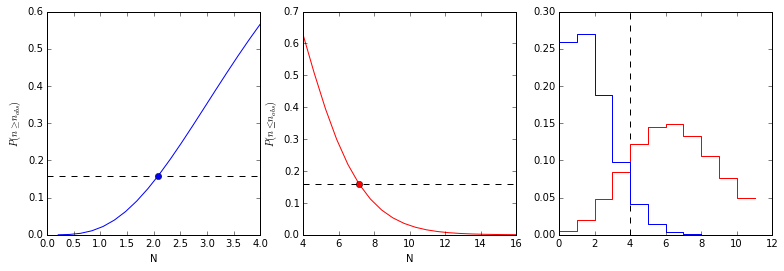

In [57]:
fig

In [58]:
print ndown, nup
Latex("$\lambda = %.2f^{+%.2f}_{-%.2f}$" % (NOBS, nup - NOBS, NOBS - ndown))

2.08566081378 7.16275317226


<IPython.core.display.Latex object>

### Question:
why we assumed that the central value for $\lambda$ is $n_{obs}=4$?

In [59]:
def get_confiderence_poisson(n):
    ym = np.array([0], dtype=np.float64)
    yp = np.array([0], dtype=np.float64)
    ROOT.RooHistError.instance().getPoissonInterval(n, ym, yp, 1)
    return ym[0], yp[0]

get_confiderence_poisson(4)

(2.0856608137771171, 7.1627531722609437)

This is the function used by RooFit to draw error bands

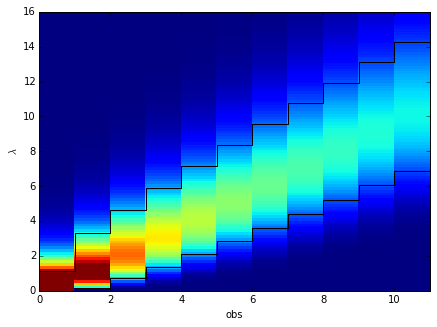

In [60]:
fig, ax = plt.subplots(figsize=(7, 5))
trues = np.linspace(1E-5, NOBS * 4, 100)
obss = np.arange(0, NOBS * 3)
v = np.zeros((len(trues), len(obss)))
limits = []
for ix, obs in enumerate(obss):
    limits.append(get_confiderence_poisson(obs))   
    for iy, true in enumerate(trues):
        v[iy, ix] = stats.poisson(true).pmf(obs)
ax.pcolormesh(obss, trues, v, vmax=np.percentile(v, 99))
ax.plot(obss, np.array(limits).T[0], 'k', drawstyle='steps-post')
ax.plot(obss, np.array(limits).T[1], 'k', drawstyle='steps-post')
ax.set_xlim(0, np.max(obss))
ax.set_xlabel('obs')
ax.set_ylabel('$\lambda$'); plt.show()

### Question: explain why this is a frequentist procedure

## Bayesian approach

$$P(\lambda|n_{obs}) = P(n_{obs}|\lambda)P(\lambda)$$

We assume the prior $P(\lambda)$ to be flat (and zero for negative values), equivalent to a constant we can ignore. Everybody agree?

$$P(\lambda|n_{obs}) = P(n_{obs}|\lambda)$$

note that $n_{obs}$ is fixed, so this is a real function $f(\lambda)$.

In [61]:
def f(true):
    return stats.poisson(true).pmf(NOBS)

import scipy
from scipy.optimize import brenth, brentq
def f_low(x):
    return scipy.integrate.quad(f, 0, x)[0] - z2p(1)

def f_hi(x):
    return scipy.integrate.quad(f, x, NOBS * 10)[0] - z2p(1)

lo_bayes, hi_bayes = brentq(f_low, 1E-5, NOBS), brentq(f_hi, NOBS, NOBS * 5)
print lo_bayes, hi_bayes
Latex("$\lambda = %.2f_{-%.2f}^{+%.2f}$" % (NOBS, NOBS - lo_bayes, hi_bayes - NOBS))

2.84030885559 7.16275317226


<IPython.core.display.Latex object>

In [62]:


def invert(f, y, a, b):
    return brentq(lambda x: f(x) - y, a, b)

lo_bayes_el = brenth(
    lambda x: scipy.integrate.quad(f, x, invert(f, f(x), x * (1 + 1E-5), NOBS * 20))[0] - (1 - z2p(1) * 2),
    1E-2, NOBS - 1E-2)
hi_bayes_el = invert(f, f(lo_bayes_el), NOBS, NOBS * 5)
print lo_bayes_el, hi_bayes_el

2.28988237908 6.40285900785


In [63]:
def width_interval(x):
    return brenth(lambda y: scipy.integrate.quad(f, x, y)[0] - (1 - z2p(1) * 2), x, NOBS * 20) - x

sol = scipy.optimize.minimize_scalar(width_interval, (1E-1, 3), bounds=(0, NOBS), method='bounded')
lo_bayes_min, hi_bayes_min = sol.x, sol.x + width_interval(sol.x)
print lo_bayes_min, hi_bayes_min

2.2898822866 6.40285891537


In [64]:
x = np.linspace(0, NOBS * 3, 100)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].plot(x, f(x))
axs[0].fill_between(np.linspace(0, lo_bayes, 50), f(np.linspace(0, lo_bayes, 50)))
axs[0].fill_between(np.linspace(hi_bayes, NOBS * 3, 50), f(np.linspace(hi_bayes, NOBS * 3, 50)))
axs[0].set_title('equal probability (central)')
axs[0].text(7, 0.16, '$\lambda = %.2f_{-%.2f}^{+%.2f}$' % (NOBS, NOBS - lo_bayes, hi_bayes - NOBS), size=15)
axs[0].text(4, 0.04, '68%', size=15)
axs[0].set_xlabel('$\lambda$')
axs[1].plot(x, f(x))
axs[1].fill_between(np.linspace(0, lo_bayes_el, 50), f(np.linspace(0, lo_bayes_el, 50)))
axs[1].fill_between(np.linspace(hi_bayes_el, NOBS * 3, 50), f(np.linspace(hi_bayes_el, NOBS * 3, 50)))
axs[1].set_title('equal likelihood')
axs[1].text(7, 0.16, '$\lambda = %.2f_{-%.2f}^{+%.2f}$' % (NOBS, NOBS - lo_bayes_el, hi_bayes_el - NOBS), size=15)
axs[1].text(3.5, 0.04, '68%', size=15)
axs[1].set_xlabel('$\lambda$')
axs[2].plot(x, f(x))
axs[2].fill_between(np.linspace(0, lo_bayes_min, 50), f(np.linspace(0, lo_bayes_min, 50)))
axs[2].fill_between(np.linspace(hi_bayes_min, NOBS * 3, 50), f(np.linspace(hi_bayes_min, NOBS * 3, 50)))
axs[2].set_title('minimum interval')
axs[2].text(7, 0.16, '$\lambda = %.2f_{-%.2f}^{+%.2f}$' % (NOBS, NOBS - lo_bayes_min, hi_bayes_min - NOBS), size=15)
axs[2].text(3.5, 0.04, '68%', size=15)
axs[2].set_xlabel('$\lambda$')
plt.close()

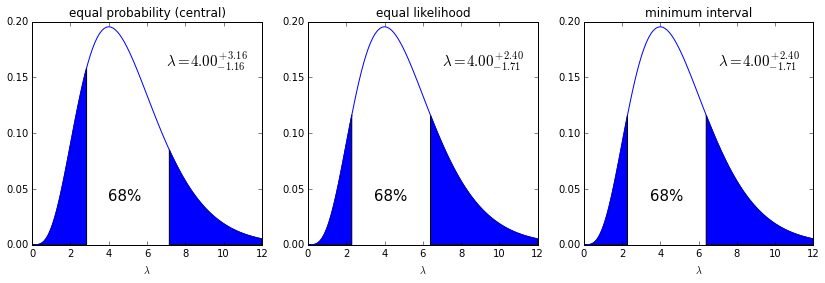

In [65]:
fig

## Profile likelihood ratio

Suppose you have composite hypothesis as 

$$H_0: \theta\in\Theta_0 \quad H_1: \theta\in\Theta_0^C$$

where $\Theta_0 = \{s=0, \ldots\}$, $\theta\in\Theta_0^C = \{s\neq 0, \ldots\}$, 

$$\lambda(x) = \frac{\sup_{\theta\in\Theta_0}{L(\theta|x)}}{\sup_{\theta\in\Theta}{L(\theta|x)}}$$

with $\Theta_0 \subset \Theta$. For example it can be $H_0: s=0$, $H_1: s\neq 0$

$$\lambda(x) = \frac{L(s=0, \hat{\hat\theta}(0)|x)}{L(\hat{s}, \hat\theta|x)}$$

where $\hat{\hat\theta}(0)$ is the value of $\theta$ which optimize the likelihood for $s=0$ (conditioned likelihood), while $\hat{s}$ and $\hat{\theta}$ are the values that optimize the likelihood without any constrains (unconditioned likelihood).

<small>It varies between 0 and 1, low values mean that the observed result is less likely to occur under the null hypothesis as compared to the alternative.

The profile likelihood ratio is nearly an optimal test-statistics</small>

<small>As shown it is important to have an analytically expression $f_q$ of the distribution of the test-statistics $q$ to compute the p-value: $\text{p-value} = \int_{q^\text{obs}}^{\infty} f_q(q) dq$. Otherwise toys must be run.</small>

## Wilks's theorem

The quantity $t=-2\log(\lambda)$ is aymptotically (large sample) distributed as a $\chi^2$ distribution with $n=\text{dim}(\Theta)-\text{dim}(\Theta_0)$ degrees of freedom.

Let resurrect the simple Poisson model $\text{Poisson}(n|s + b)$. This time, instead of using the number of observed events as test-statistics, let use the profile likelihood ratio.

In [66]:
S, B = 30, 200  # expected values

ws_poisson = ROOT.RooWorkspace('ws_poisson')
b = ws_poisson.factory("b[%f]" % B)
n_exp = ws_poisson.factory("sum::n_exp(s[%f, -500, 500], b)" % S)
pdf = ws_poisson.factory("Poisson::pdf(n_obs[0, 1000], n_exp)")
aset = ROOT.RooArgSet(ws_poisson.var('n_obs'))
data = pdf.generate(aset, 1)  # generate with 1 entry
print "observed = ", data.get(0).first().getVal()

observed =  249.0


In [67]:
# create a MC linked to the ws
sbModel = RooStats.ModelConfig("sbmodel", ws_poisson)   
sbModel.SetPdf(pdf)
sbModel.SetObservables('n_obs')  # it understands variable-names
sbModel.SetParametersOfInterest('s')
# save the value of s for (s+b)-hypothesis
sbModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(sbModel)  # import is a keyword in python

bModel = sbModel.Clone("bmodel")  # create a bkg-only model
ws_poisson.var('s').setVal(0)             # with no signal
bModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(bModel);

In [68]:
profll = RooStats.ProfileLikelihoodTestStat(bModel.GetPdf())
# this modify a bit our test statistics
#profll.SetOneSidedDiscovery(1)

hypoCalc = RooStats.FrequentistCalculator(data, sbModel, bModel)
hypoCalc.SetToys(100000, 5000)  # generate much more toys for bkg-only

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(profll)
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)


=== Using the following for bmodel ===
Observables:             RooArgSet:: = (n_obs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::pdf[ x=n_obs mean=n_exp ] = 3.71273e-71
Snapshot:                
  1) 0xe7e0fc0 RooRealVar:: s = 0  L(-500 - 500)  "s"


=== Using the following for sbmodel ===
Observables:             RooArgSet:: = (n_obs)
Parameters of Interest:  RooArgSet:: = (s)
PDF:                     RooPoisson::pdf[ x=n_obs mean=n_exp ] = 3.71273e-71
Snapshot:                
  1) 0xe7e0fc0 RooRealVar:: s = 30  L(-500 - 500)  "s"

[#0] PROGRESS:Generation -- Test Statistic on data: 5.56475
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0] PROGRESS:Generation -- generated toys: 500 / 100000
[#0] PROGRESS:Generation -- generated toys: 1000 / 100000
[#0] PROGRESS:Generation -- generated toys: 1500 / 100000
[#0] PROGRESS:Generation -- generated toys: 2000 / 100000
[#0] PROGRESS:Generation -- generated toys: 2500 / 1000

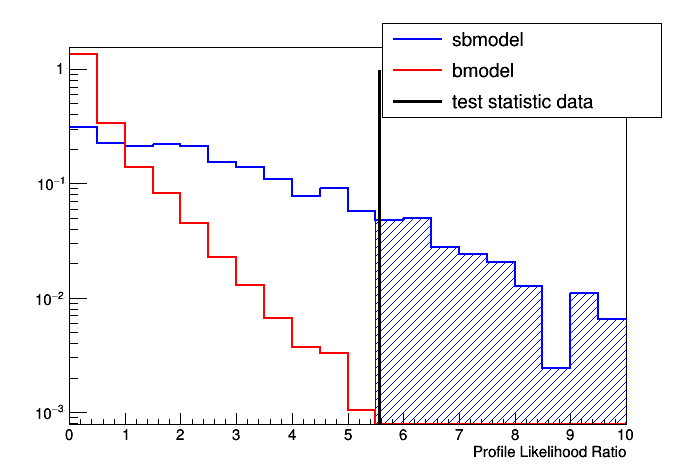

pvalue =  0.00088  significance =  3.12800030277
n -- generated toys: 28500 / 100000
[#0] PROGRESS:Generation -- generated toys: 29000 / 100000
[#0] PROGRESS:Generation -- generated toys: 29500 / 100000
[#0] PROGRESS:Generation -- generated toys: 30000 / 100000
[#0] PROGRESS:Generation -- generated toys: 30500 / 100000
[#0] PROGRESS:Generation -- generated toys: 31000 / 100000
[#0] PROGRESS:Generation -- generated toys: 31500 / 100000
[#0] PROGRESS:Generation -- generated toys: 32000 / 100000
[#0] PROGRESS:Generation -- generated toys: 32500 / 100000
[#0] PROGRESS:Generation -- generated toys: 33000 / 100000
[#0] PROGRESS:Generation -- generated toys: 33500 / 100000
[#0] PROGRESS:Generation -- generated toys: 34000 / 100000
[#0] PROGRESS:Generation -- generated toys: 34500 / 100000
[#0] PROGRESS:Generation -- generated toys: 35000 / 100000
[#0] PROGRESS:Generation -- generated toys: 35500 / 100000
[#0] PROGRESS:Generation -- generated toys: 36000 / 100000
[#0] PROGRESS:Generation -- ge

In [69]:
plot = RooStats.HypoTestPlot(htr, 20, 0, 10)
canvas = ROOT.TCanvas()
plot.Draw()
canvas.SetLogy(); canvas.Draw()
print "pvalue = ", htr.NullPValue(), " significance = ", htr.Significance()

We can also use the AsymtoticCalculator, which instead of using the empirical distribution of the likelihood ratio from toys, it uses the asymptotic distribution ($\chi^2_1$ distribution for the simple likelihood ratio)

In [70]:
hypoCalc = RooStats.AsymptoticCalculator(data, sbModel, bModel)
hypoCalc.SetOneSidedDiscovery(True)
htr = hypoCalc.GetHypoTest()
print "pvalue =", htr.NullPValue(), " significance =", htr.Significance()

pvalue = 0.000424828860905  significance = 3.33608960891
toys: 62500 / 100000
[#0] PROGRESS:Generation -- generated toys: 63000 / 100000
[#0] PROGRESS:Generation -- generated toys: 63500 / 100000
[#0] PROGRESS:Generation -- generated toys: 64000 / 100000
[#0] PROGRESS:Generation -- generated toys: 64500 / 100000
[#0] PROGRESS:Generation -- generated toys: 65000 / 100000
[#0] PROGRESS:Generation -- generated toys: 65500 / 100000
[#0] PROGRESS:Generation -- generated toys: 66000 / 100000
[#0] PROGRESS:Generation -- generated toys: 66500 / 100000
[#0] PROGRESS:Generation -- generated toys: 67000 / 100000
[#0] PROGRESS:Generation -- generated toys: 67500 / 100000
[#0] PROGRESS:Generation -- generated toys: 68000 / 100000
[#0] PROGRESS:Generation -- generated toys: 68500 / 100000
[#0] PROGRESS:Generation -- generated toys: 69000 / 100000
[#0] PROGRESS:Generation -- generated toys: 69500 / 100000
[#0] PROGRESS:Generation -- generated toys: 70000 / 100000
[#0] PROGRESS:Generation -- generated

## On/off problem

Let's introduce a classical problem in high-energy / astro / ... physics. Suppose you have a source that can contain signal and background events. You have an other source that contains only background events and the background in the two source is correlated.

This is the case when you have a control region, with only background, and a signal region with signal plus background. Usually the correlation of the background between the two region comes from a simulation. In astrophysics this can be the case when with telescope one wants to see if there is source in a particular region of the sky, using as control region the average of regions where there are no known source.



In term of random variables:

$$ N_{SR} = S + B \qquad N_{CR} = \alpha B$$

with $S$ and $B$ distributed as Poisson distribution. What we observe are the number of events in the signal region $n_{SR}$ and in the control region $n_{CR}$. $\alpha$ is assumed to be a known constant. We can write the likelihood as:

$$L(s, b|N_{SR}, N_{CR}) = \text{Pois}(N_{SR}|s + b) \text{Pois}(N_{CR}|\alpha b)$$

remember that $\alpha$ is a known constant. The test statistics is based on the profiled likelihood ratio:

$$-2\log\lambda = -2\log\frac{\sup_{b \in [0, \infty], s\in\{0\}}{L(s, b)}}{\sup_{b\in [0, \infty], s\in [0, \infty]}{L(s, b)}} = -2\log\frac{L(0, \hat{\hat{b}}(s=0))}{L(\hat{s}, \hat{b})}$$


In [153]:
ws_onoff = ROOT.RooWorkspace('ws_onoff')
model_sr = ws_onoff.factory("Poisson:N_SR(n_sr[0, 5000], sum:s_plus_b(s[15, 0, 100], b[50, 0, 100]))")
model_cr = ws_onoff.factory("Poisson:N_CR(n_cr[0, 5000], prod:alpha_x_b(alpha[10, 0, 10], b))")
model = ws_onoff.factory("PROD:model(N_SR, N_CR)")
ws_onoff.var("alpha").setConstant(True)

sbModel = RooStats.ModelConfig('sbModel', ws_onoff)
sbModel.SetObservables('n_sr,n_cr')
sbModel.SetParametersOfInterest('s')
sbModel.SetPdf('model')
sbModel.SetSnapshot(ROOT.RooArgSet(ws_onoff.var('s')))
getattr(ws_onoff, 'import')(sbModel)

bModel = sbModel.Clone("bModel")
ws_onoff.var('s').setVal(0)
bModel.SetSnapshot(bModel.GetParametersOfInterest())

ws_onoff.Print()
ws_onoff.writeToFile('onoff.root')

False


RooWorkspace(ws_onoff) ws_onoff contents

variables
---------
(alpha,b,n_cr,n_sr,s)

p.d.f.s
-------
RooPoisson::N_CR[ x=n_cr mean=alpha_x_b ] = 0
RooPoisson::N_SR[ x=n_sr mean=s_plus_b ] = 0
RooProdPdf::model[ N_SR * N_CR ] = 0

functions
--------
RooProduct::alpha_x_b[ alpha * b ] = 500
RooAddition::s_plus_b[ s + b ] = 50

parameter snapshots
-------------------
sbModel__snapshot = (s=15)
bModel__snapshot = (s=0)

named sets
----------
bModel__snapshot:(s)
sbModel_Observables:(n_sr,n_cr)
sbModel_POI:(s)
sbModel__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::sbModel



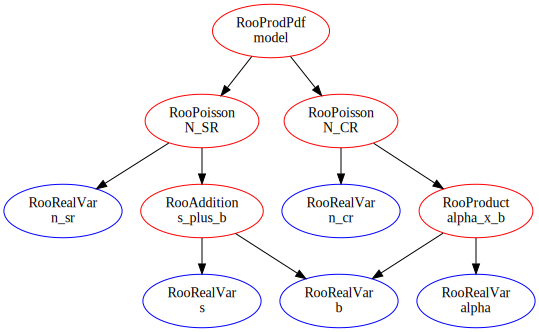

In [154]:
model.graphVizTree("on_off_graph.dot")
!dot -Tsvg on_off_graph.dot > on_off_graph.svg; rm on_off_graph.dot
SVG("on_off_graph.svg")

In [155]:
sbModel.LoadSnapshot()
data = model.generate(bModel.GetObservables(), 1)
print "observed  N_SR = %.f, N_CR = %.f" % tuple([x.getVal() for x in iter_collection(data.get(0))])
model.fitTo(data)
print "best fit     s        b"
print "SR    {:>8.1f} {:>8.1f}".format(ws_onoff.var('s').getVal(), ws_onoff.var('b').getVal())
print "CR             {:>8.1f}".format(ws_onoff.function('alpha_x_b').getVal())

observed  N_SR = 60, N_CR = 494
best fit     s        b
SR        10.6     49.4
CR                494.1
[#1] INFO:Minization -- RooMinuit::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (N_SR,N_CR)
 **********
 **   13 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=7.22146 FROM MIGRAD    STATUS=INITIATE        8 CALLS           9 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  b            5.00000e+01   1.00000e+01   2.01358e-01   9.84615e+00
   2  s            1.50000e+01   7.50000e+00   2.16811e-01   2.74670e+00
                               ERR DEF= 0.5
 MIGRAD MINIM

In [156]:
profll = RooStats.ProfileLikelihoodTestStat(bModel.GetPdf())
# this modify a bit our test statistics
profll.SetOneSidedDiscovery(True)

hypoCalc = RooStats.FrequentistCalculator(data, sbModel, bModel)
hypoCalc.SetToys(10000, 500)

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(profll)
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)


=== Using the following for bModel ===
Observables:             RooArgSet:: = (n_sr,n_cr)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (b)
PDF:                     RooProdPdf::model[ N_SR * N_CR ] = 0
Snapshot:                
  1) 0x12182fc0 RooRealVar:: s = 0  L(0 - 100)  "s"


=== Using the following for sbModel ===
Observables:             RooArgSet:: = (n_sr,n_cr)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (b)
PDF:                     RooProdPdf::model[ N_SR * N_CR ] = 0
Snapshot:                
  1) 0x12182fc0 RooRealVar:: s = 15  L(0 - 100)  "s"

[#0] PROGRESS:Generation -- Test Statistic on data: 0.960928
[#1] INFO:InputArguments -- Profiling conditional MLEs for Null.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0] PROGRESS:Generation -- generated toys: 500 / 10000
[#0] PROGRESS:Generation -- generated toys: 1000 / 10000
[#0] PROGRESS:Generation -- generated toys: 150

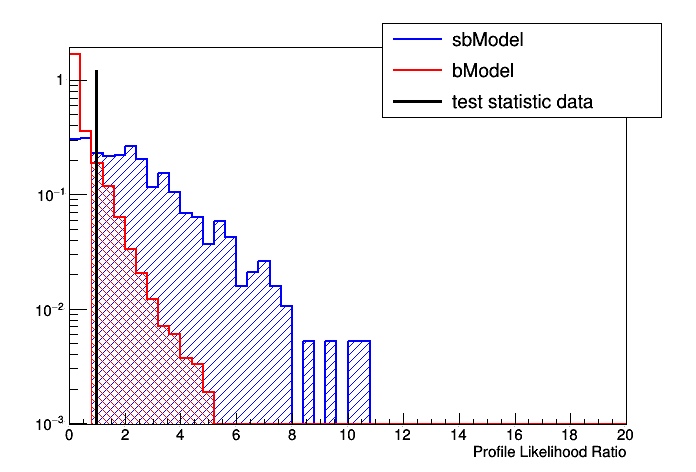

pvalue =  0.0801  significance =  1.40439923019


In [158]:
plot = RooStats.HypoTestPlot(htr, 50, 0, 20)
canvas = ROOT.TCanvas()
plot.Draw()
canvas.SetLogy()
canvas.Draw()
print "pvalue = ", htr.NullPValue(), " significance = ", htr.Significance()

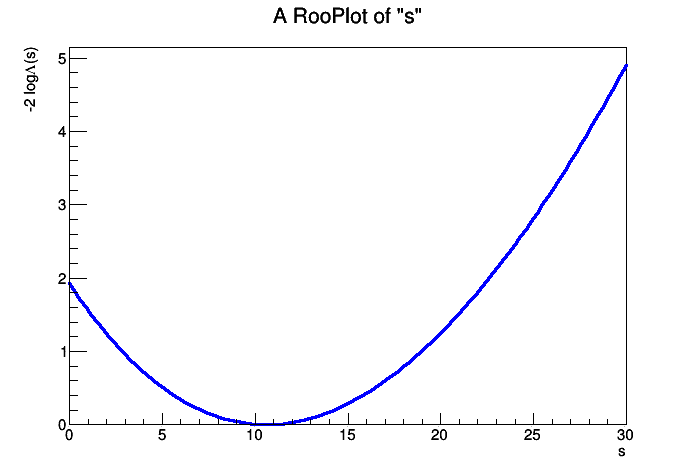

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[s]) minimum found at (s=10.6035)
..........................................................................................................................................................................................................

In [159]:
# create profiled log-likelihood
prof = model.createNLL(data).createProfile(ROOT.RooArgSet(ws_onoff.var('s')))
# multiply by 2
minus2LL = ROOT.RooFormulaVar("minus2LL", "2 * @0", ROOT.RooArgList(prof))
frame = ws_onoff.var('s').frame(0, 30)
minus2LL.plotOn(frame)
frame.SetYTitle("-2 log#Lambda(s)")
canvas = ROOT.TCanvas()
frame.Draw()
canvas.Draw()

In [160]:
hypoCalc = RooStats.AsymptoticCalculator(data, sbModel, bModel)
hypoCalc.SetOneSidedDiscovery(True)
htr = hypoCalc.GetHypoTest()
print "pvalue =", htr.NullPValue(), " significance =", htr.Significance()

pvalue_exp = RooStats.AsymptoticCalculator.GetExpectedPValues(htr.NullPValue(), htr.AlternatePValue(), False, True)
significance_exp = ROOT.Math.normal_quantile_c(pvalue_exp, 1)
print "expected p-value = ", pvalue_exp, " significance =", significance_exp                

pvalue = 0.0828261234044  significance = 1.38631005841
expected p-value =  0.0523517293198  significance = 1.6224666952
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize....
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize - Find  best unconditional NLL on observed data
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 ** 1828 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 b            4.94059e+01  2.22197e+00    0.00000e+00  1.00000e+02
     2 s            1.06392e+01  5.31959e+00    0.00000e+00  1.00000e+02
 **********
 ** 1829 **SET ERR         0.5
 **********
 **********
 ** 1830 **SET PRINT           0
 **********
 **********
 ** 1831 **SET STR           1
 **********
 **********
 ** 1832 **MIGRAD        1000           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=6.98787 FROM MIGRAD    

# Lecture 3

<p style="text-align: center;"><i class="icon-user icon-2x"> [ruggero.turra@mi.infn.it](mailto:ruggero.turra@mi.infn.it)</i></p>
<br/>

## Content of the lecture

   * Systematics
   * Shape analysis
   * Test statistic for discovery and exclusions
   * CLs

## Systematics

How we can incorporate systematics inside our model? Suppose we know the parameter $\alpha$ with a relative uncertainty $\sigma_\alpha$. We can imagine that there is another measurement (auxiliary measurement), that measured $\alpha$ (the parameter of the model of the auxiliary measurement) and observed $a$. We can write the likelihood of the auxiliary measurement as $L(a|\alpha) = N(a|\alpha, \delta_\alpha)$, if assume that $a$ is normally distributed aroud the true value $\alpha$ and $\delta\alpha$ is the absolute error on $\alpha$

We can join the auxiliary measurement with our on/off model:

$$L(s, b, a|N_{SR}, N_{CR}, \alpha) = L(s, b|N_{SR}, N_{CR}) L(a|\alpha)$$

or more explicitely:

$$\text{Pois}(N_{SR}|s + b) \text{Pois}(N_{CR}|\alpha b) N(a|\alpha, \delta_\alpha)$$

Usually this is written as:

$$\text{Pois}(N_{SR}|s + b) \text{Pois}(N_{CR}|a (1 + \sigma_\alpha\theta_\alpha) b) N(0|\alpha, 1)$$

The first term is called the "physical" pdf, while the second is called the "constraints".




In [78]:
#ws = ws_onoff_withsys = ws_onoff.Clone("ws_onoff_withsys")
f = ROOT.TFile.Open("onoff.root")
ws_onoff = f.Get("ws_onoff")

# create the term kalpha = (1 + sigma * theta) with a relative error of 10%
ws_onoff.factory('expr:kalpha("1 + @0 * @1", {sigma_alpha[0.1], theta_alpha[0, -5, 5]})')
# create new pdf model replacing alpha -> kalpha
ws_onoff.factory('EDIT:model_with_sys(model, alpha=kalpha)')

# create new workspace
ws_onoff_sys = ROOT.RooWorkspace('ws_onoff_sys')
getattr(ws_onoff_sys, 'import')(ws_onoff.pdf('model_with_sys'))
# create the constraint
ws_onoff_sys.factory("Gaussian:constraint_alpha(global_alpha[0, -5, 5], theta_alpha, 1)")
ws_onoff_sys.var("global_alpha").setConstant(True)
# final pdf
model = ws_onoff_sys.factory("PROD:model_constrained(model_with_sys, constraint_alpha)")

[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooProdPdf::model_with_sys
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooPoisson::N_SR
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooRealVar::n_sr
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooAddition::s_plus_b
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooRealVar::s
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooRealVar::b
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooPoisson::N_CR_model_with_sys
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooRealVar::n_cr
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooProduct::alpha_x_b_model_with_sys
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws_onoff_sys) importing RooFormulaVar::kalpha
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws

In [79]:
ws_onoff_sys.Print()


RooWorkspace(ws_onoff_sys) ws_onoff_sys contents

variables
---------
(b,global_alpha,n_cr,n_sr,s,sigma_alpha,theta_alpha)

p.d.f.s
-------
RooPoisson::N_CR_model_with_sys[ x=n_cr mean=alpha_x_b_model_with_sys ] = 0
RooPoisson::N_SR[ x=n_sr mean=s_plus_b ] = 0
RooGaussian::constraint_alpha[ x=global_alpha mean=theta_alpha sigma=1 ] = 1
RooProdPdf::model_constrained[ model_with_sys * constraint_alpha ] = 0
RooProdPdf::model_with_sys[ N_SR * N_CR_model_with_sys ] = 0

functions
--------
RooProduct::alpha_x_b_model_with_sys[ kalpha * b ] = 50
RooFormulaVar::kalpha[ actualVars=(sigma_alpha,theta_alpha) formula="1+@0*@1" ] = 1
RooAddition::s_plus_b[ s + b ] = 50



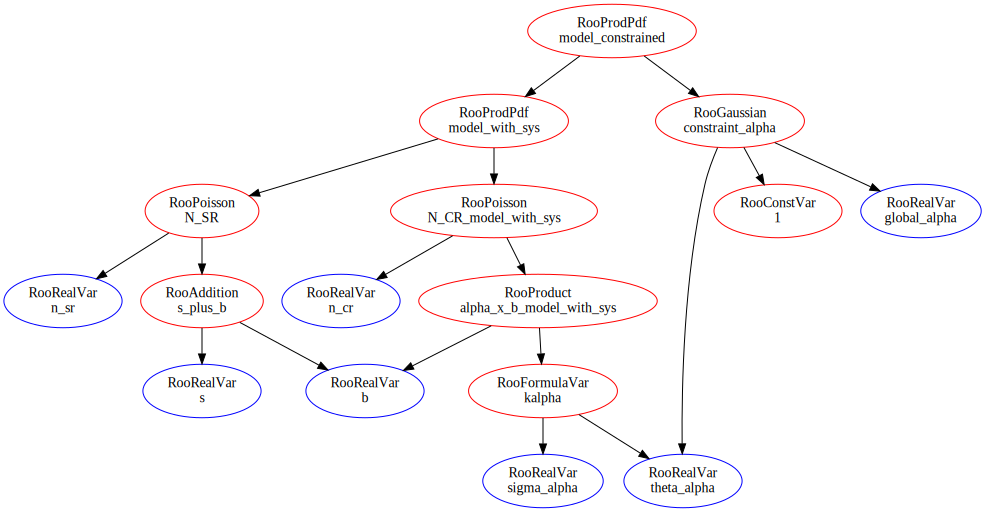

In [80]:
model.graphVizTree("on_off_with_sys_graph.dot")
!dot -Tsvg on_off_with_sys_graph.dot > on_off_with_sys_graph.svg; rm on_off_with_sys_graph.dot
s = SVG("on_off_with_sys_graph.svg")
s.data = s.data.replace('width="985pt"', 'width="90%"'); s

In [81]:
sbModel = ROOT.RooStats.ModelConfig(ws_onoff_sys)
sbModel.SetPdf('model_constrained')
sbModel.SetParametersOfInterest('s')
sbModel.SetObservables('n_sr,n_cr')
sbModel.SetNuisanceParameters('theta_alpha')
ws_onoff_sys.var('s').setVal(30)
sbModel.SetSnapshot(ROOT.RooArgSet(ws_onoff_sys.var('s')))
getattr(ws_onoff_sys, 'import')(sbModel)

bModel = sbModel.Clone("bModel")
ws_onoff_sys.var('s').setVal(0)
bModel.SetSnapshot(bModel.GetParametersOfInterest())
getattr(ws_onoff_sys, 'import')(bModel)

ws_onoff_sys.writeToFile('onoff_sys.root')

False

In [82]:
sbModel.LoadSnapshot()
ws_onoff_sys.var('s').Print()
data = model.generate(bModel.GetObservables(), 1)
print "observed  N_SR = %.f, N_CR = %.f" % tuple([x.getVal() for x in iter_collection(data.get(0))])
model.fitTo(data)
print "best fit"
print "SR {:>8.1f} {:>8.1f}".format(ws_onoff_sys.var('s').getVal(), ws_onoff_sys.var('b').getVal())
print "CR          {:>8.1f}".format(ws_onoff_sys.function('alpha_x_b_model_with_sys').getVal())

observed  N_SR = 69, N_CR = 57
best fit
SR     12.0     57.0
CR              57.0
RooRealVar::s = 30  L(0 - 100) 

[#1] INFO:Minization --  Including the following contraint terms in minimization: (constraint_alpha)
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_constrained_model_constrainedData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinuit::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (N_SR,N_CR_model_with_sys)
 **********
 **   13 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=8.16019 FROM MIGRAD    STATUS=INITIATE       12 CALLS          13 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP   

In [83]:
# create profiled log-likelihood as a function of s
ws_onoff_sys.var('theta_alpha').setConstant(False)
prof = model.createNLL(data).createProfile(ROOT.RooArgSet(ws_onoff_sys.var('s')))
# multiply by 2
minus2LL = ROOT.RooFormulaVar("minus2LL", "2 * @0", ROOT.RooArgList(prof))
frame = ws_onoff.var('s').frame(0, 60)
minus2LL.plotOn(frame)

ws_onoff_sys.var('theta_alpha').setConstant(True)
minus2LL.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed))
frame.SetYTitle("-2 log#Lambda(s)")

[#1] INFO:Minization --  Including the following contraint terms in minimization: (constraint_alpha)
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_constrained_model_constrainedData_with_constr_Profile[s]) Creating instance of MINUIT
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_constrained_model_constrainedData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_constrained_model_constrainedData_with_constr_Profile[s]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_constrained_model_constrainedData_with_constr_Profile[s]) minimum found at (s=11.9615)
..........................................................................................................................................................................................................
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_m

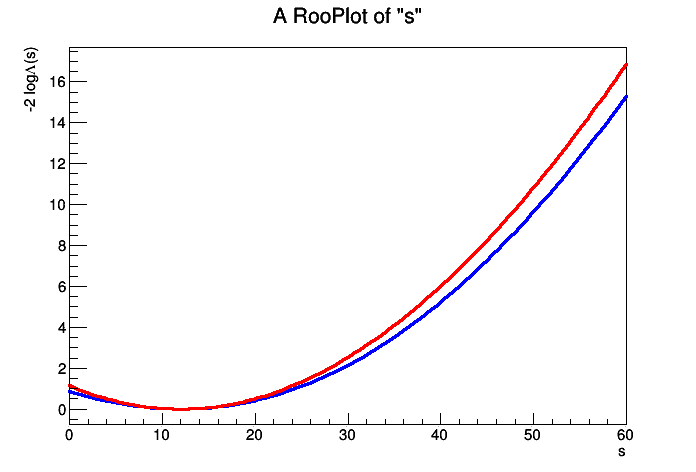

In [84]:
canvas = ROOT.TCanvas()
frame.Draw()
canvas.Draw()

### (Big) exercize

Suppose you are looking for a signal in a SR. There are two main background on the signal region, due to two different physical processes, B1 and B2. You also have two CRs. The simulation predicts the following countings for an equivalent luminosity of 1/fb.

|     |  SR |CR1|CR2|
|-----|-----|-----|-----|
|  B1 |  10 | 100 | 20  |
|  B2 |  20 |  30 | 500 |

You don't trust the cross section of the background, so you assume a degree of freedom for every process. For example:

$$n_{B1}^{SR,exp} = L\times k_{B1}\times n_{B1}^{SR,mc}$$
$$n_{B1}^{CR1,exp} = L\times k_{B1}\times n_{B1}^{CR1,mc}$$

where $L$ is the observed luminosity. Note that we are using the correlation between SR/CR1/CR2 of the simulation. Assume  L=10/fb +/- 5%. 

Suppose you analysis is blinded (you haven't look to the signal region) and you observe: CR1=1509, CR2=5017 events.

How many events do you have to observe in the signal region to claim a discovery at 3 sigma (what is the acceptance region)? What is the impact of the systematics? Bonus: take into account the MC statistical uncertainty of 3% for every prediction.

For this kind of analyses usually [HistFactory](https://twiki.cern.ch/twiki/bin/view/RooStats/HistFactory) is used to produce the workspace.

## Shape analysis

In more complicate analysis you don't look just to the number of events in specific region but you look to the distribution of the events as a function of a continuos variable (e.g. invariant mass).

$$L(\alpha|\{m_i\}_{i=1}^n) = \text{Pois}[n|N_s(\alpha) + N_b(\alpha)] \prod_{i=1}^n\left(\frac{N_s(\alpha) f_s[m_i|\alpha] + N_b(\alpha) f_b[m_i|\alpha]}{N_s(\alpha)+N_b(\alpha)}\right)\times\prod_j L(a_j|\alpha_j)$$

Where $\alpha$ is a set of nuisance parameters, $\{m_i\}_{i=1}^n$ are the data, $N_s$ and $N_b$ the predicted number of signal and background events, $f_s$ and $f_b$ the pdf describing the continuos observable.

The last term is the product of all the constraints of the nuisance parameters (not all the nuisance parameters need to be constrained by auxiliary measurements). The other term is the extended likelihood of the s+b model.

If the signal is localised the background shape can be fully data-driven. This means that the nuisance parameters for the background shape are completely free.

### Example model

Suppose we observe the invariant mass distribution and we are searching for a narrow resonance in the spectrum. Our signal + background model is (after many careful studies) an exponential plus a gaussian. We also know the expected number of events for the signal under a particular theory. We want to be able to parametrize also similar model, where the number of signal events is multiplied by the "signal multiplier", $\mu$. So we will write the number of signal events as $\mu n_{exp}$ where $n_{exp}$ are the one from the nominal theory. In this way we can also write the background-only model as the special case for $\mu=0$. The number of background events are not well know by the theory, so we can estimate them from data, which means that $n_b$ is a nuisance parameters in the model.

In [85]:
ws = ROOT.RooWorkspace("ws_shape")
ws.factory("mH[125, 110, 190]")  # mass of the resonance
ws.factory("mass[100, 200]")  # observed invariant mass
ws.factory('expr:kpeak("1 + @0 * @1", {sigma_mH[0.1], theta_mH[0, -5, 5]})')
ws.factory('expr:peak("@0 * @1", {mH, kpeak})')   # peak position for signal
ws.factory('expr:kwidth("1 + @0 * @1", {sigma_width[0.05], theta_width[0, -5, 5]})')
ws.factory('expr:width("@0 * @1", {nominal_width[100], kwidth})')
ws.factory("RooGaussian:signal(mass, peak, width)")
ws.factory("RooExponential:background(mass, tau[-0.1, -0.5, -0.01])")
ws.factory("nbkg[0, 1000]")
ws.factory('expr:lumi("@0 * (1 + exp(@1 * @2))", {nominal_lumi[25], sigma_lumi[0.02], theta_lumi[0, -5, 5]})')
ws.factory('expr:efficiency("@0 * (1 + exp(@1 * @2))", {nominal_efficiency[0.6], sigma_efficiency[0.05], theta_efficiency[0, -5, 5]})')
ws.factory('expr:nsignal_theory("100 + @0 * 0.1", {mH})')
ws.factory('prod:nsignal(nsignal_theory, mu[0, 5])')
ws.factory("SUM:phys_pdf(nsignal * signal, nbkg * background)")
ws.factory("RooGaussian:constrain_peak(global_peak[0, -5, 5], theta_mH, 1)")
ws.factory("RooGaussian:constrain_width(global_width[0, -5, 5], theta_width, 1)")
ws.factory("RooGaussian:constrain_lumi(global_lumi[0, -5, 5], theta_lumi, 1)")
ws.factory("RooGaussian:constrain_eff(global_efficiency[0, -5, 5], theta_efficiency, 1)")
ws.factory("PROD:constraints(constrain_peak)")

<ROOT.RooProdPdf object ("constraints") at 0x107b0f30>

## Test statistics $t_\mu$ and $\tilde{t}_\mu$

$$ t_\mu = -2\log\lambda (\mu) = -2\log \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(\hat{\mu}, \hat{\theta})}$$

High value means incompatiblity with data. If we want to test a specific $\mu$ we can compute the p-value $= \int_{t_{\mu, obs}}^\infty f(t_\mu|\mu) dt_\mu$. Values can be excluded because they are too low, or too high.

Usually we can assume that $\mu\geq 0$, so we need a new test statistic:

$$ \tilde{t}_\mu = -2\log \tilde\lambda(\mu)$$

$$ \tilde\lambda(\mu) = \begin{cases} 
      \hfill \frac{L(0, \hat{\hat{\theta}}(\mu=0))}{L(\hat{\mu}, \hat{\theta})}    \hfill & \mu < 0 \\
      \hfill \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(\hat{\mu}, \hat{\theta})} \hfill & \mu \geq 0 \\
  \end{cases}$$
  
Also in this case, values can be excluded because they are too low, or too high.

## $q_0$ statistics for discovery of positive signal

For discovery we want to exclude the hypothesis $s=0$ (background-only), assuming $\mu\geq 0$. Defining $q_0 = \tilde{t}_0$:

$$ q_0 = 
\begin{cases} 
-2\log\lambda(0)\qquad &\hat \mu\geq 0 \\
0\qquad &\hat \mu < 0
\end{cases}
$$

If $\hat s<0$ it means that we are observing less events than the one predicted by the background-only model. Since we are truncating the the definition of test statistics we are not considering downward fluctuation as discrepancies with the model. High value of $\hat\ s$ means high value of $q_0$ and large discrepancy with the background-only model. The p-value is computed as usual:

$$ \text{p-value} = p_0 = \int_{q_{0, obs}}^\infty f(q_0|\mu=0)\, dq_0$$

### Question
If we assume that the background model is true, how many times we will get $\hat \mu<0$?

## $q_\mu$ statistic for exclusion
Suppose we want to put un upper limit, so we define as null hypothesis to exclude the hypotesis signal+background with $\mu$ as signal multiplier.

$$
q_\mu=\begin{cases}
-2\log\lambda(\mu)\qquad & \hat\mu \leq \mu\\
0 \qquad & \hat\mu > \mu
\end{cases}
$$

we set $q_\mu=0$ when observing a value of $\mu$ greater than the one we are observing since we don't want it to enter in the rejection region when doing an upper limit; we don't want that upper fluctuation count as bad agreement with data. The p-value is computed in the usual way, assuming the null-hypothesis ($\mu$) true:

$$ \text{p-value} = p_\mu = \int_{q_{\mu, obs}}^\infty f(q_\mu|\mu)\, dq_\mu$$


### Questions
What is the relation between $q_\mu$ and $q_0$? Are you looking in the same tail of $\mu$?

## Alternative test $\tilde{q}_\mu$ for exclusion

## The CLs problem

Suppose you have a counting experiments. You know $b=3$, you observe $n=0$. What is the exclusion for $s$ at 5%? If we use directly the number of observed events as test statistics:

$$\text{p-value} = P(n\leq n_{obs}|s + b) = \sum_{0\leq n\leq n_{obs}} Pois(n|\lambda=s+b)$$

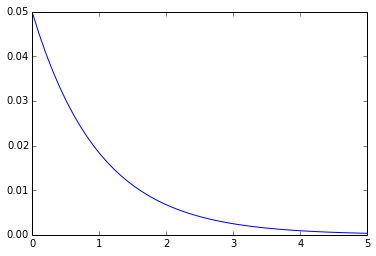

In [86]:
b = 3; s = np.linspace(0, 5, 50)
pvalue_sb = stats.poisson(b + s).cdf(0)
plt.plot(s, pvalue_sb);

All the value of $s$ are excluded! Also $s=0$. The problem is that the experiment is not able to distinguish very small value of $s$ with respect to $s=0$. So, the p-value should be corrected.

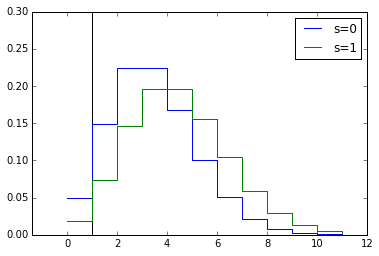

In [87]:
x = np.arange(0, 12)
y1 = stats.poisson(3).pmf(x)
y2 = stats.poisson(3 + 1).pmf(x)
plt.plot(x, y1, drawstyle="steps-post", label='s=0');
plt.plot(x, y2, drawstyle="steps-post", label='s=1');
plt.vlines(1, 0, 0.3)
plt.xlim(-1.4, 12)
plt.legend();

In [88]:
pvalue_b = stats.poisson(b).sf(0)
pvalue_b

0.95021293163213605